In [1]:
# Set OpenMP environment variables early to avoid libiomp conflicts
import os
os.environ.setdefault("KMP_DUPLICATE_LIB_OK", "TRUE")
os.environ.setdefault("OMP_NUM_THREADS", "1")

import numpy as np
import pandas as pd
import sympy as sy

# Try importing torch, but don't fail if it's not available
try:
    import torch
    TORCH_AVAILABLE = True
    print(f"PyTorch {torch.__version__} is available")
except ImportError:
    TORCH_AVAILABLE = False
    print("Warning: PyTorch is not installed. Using numpy/scipy for diagonalization.")
    torch = None

import ujson as uj

from copy import deepcopy
from functools import partial
from pathlib import Path

from sympy.physics.wigner import wigner_3j, wigner_6j
from numpy import linalg as LA
from IPython.display import Latex, display
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.collections import LineCollection
%matplotlib inline
import seaborn as sns

from scipy.optimize import least_squares
from scipy.stats import norm

import Energy_Levels_old as EL
from Energy_Levels_old import MoleculeLevels
from Energy_Levels_old import (
    branching_ratios,
    Calculate_TDMs,
    Calculate_TDM_evecs,
    Calculate_forbidden_TDM_evecs,
    Calculate_forbidden_TDMs,
)

print("All imports successful!")

# sns.set()
# sns.set_palette('bright')
# np.set_printoptions(precision=9, suppress=True)
# from tabulate import tabulate


PyTorch 2.5.1+cu121 is available
All imports successful!


In [2]:
# Torch device configuration and GPU-ready diagonalization hooks
# Only configure torch if it's available. Probe CUDA in a short subprocess
# and default to CPU if the probe fails to avoid kernel/driver crashes.
import subprocess, sys, time

if TORCH_AVAILABLE:
    try:
        # Default to CPU; enable CUDA only if a quick safe probe succeeds.
        TORCH_DEVICE = torch.device("cpu")
        cuda_ok = False
        if torch.cuda.is_available():
            probe_code = (
                "import torch, sys\n"
                "try:\n"
                "    x = torch.tensor([1.0], dtype=torch.float32).to('cuda')\n"
                "    torch.cuda.synchronize()\n"
                "    print('cuda_ok')\n"
                "except Exception as e:\n"
                "    print('cuda_fail', e)\n"
                "    sys.exit(1)\n"
            )
            try:
                res = subprocess.run([sys.executable, "-c", probe_code], capture_output=True, text=True, timeout=10)
                if res.returncode == 0 and "cuda_ok" in res.stdout:
                    TORCH_DEVICE = torch.device("cuda")
                    cuda_ok = True
                else:
                    print("CUDA probe failed; output:", res.stdout, res.stderr)
            except Exception as e:
                print("CUDA probe subprocess error:", e)

        print(f"Using torch device: {TORCH_DEVICE} (cuda_ok={cuda_ok})")
    except Exception as e:
        print(f"Warning: Could not configure torch device: {e}")
        TORCH_AVAILABLE = False
        TORCH_DEVICE = torch.device("cpu")
else:
    TORCH_DEVICE = None
    print("Torch not available, using numpy/scipy for diagonalization")

# Store original functions
if not hasattr(EL, "diagonalize_cpu"):
    EL.diagonalize_cpu = EL.diagonalize
    EL.diagonalize_batch_cpu = EL.diagonalize_batch

# ---- GPU profiling statistics ----
GPU_PROFILING = {
    "diagonalize_calls": 0,
    "diagonalize_cuda_calls": 0,
    "diagonalize_cpu_calls": 0,
    "diagonalize_batch_calls": 0,
    "diagonalize_batch_cuda_calls": 0,
    "diagonalize_batch_cpu_calls": 0,
    "total_time_cuda": 0.0,
    "total_time_cpu": 0.0,
    "total_time_batch_cuda": 0.0,
    "total_time_batch_cpu": 0.0,
}

def print_gpu_profile():
    """Print GPU profiling summary."""
    print("\n" + "="*70)
    print("GPU PROFILING SUMMARY")
    print("="*70)
    print(f"Single diagonalize() calls: {GPU_PROFILING['diagonalize_calls']}")
    print(f"  ├─ CUDA: {GPU_PROFILING['diagonalize_cuda_calls']} (total time: {GPU_PROFILING['total_time_cuda']:.4f}s)")
    print(f"  └─ CPU:  {GPU_PROFILING['diagonalize_cpu_calls']} (total time: {GPU_PROFILING['total_time_cpu']:.4f}s)")
    print(f"\nBatch diagonalize_batch() calls: {GPU_PROFILING['diagonalize_batch_calls']}")
    print(f"  ├─ CUDA: {GPU_PROFILING['diagonalize_batch_cuda_calls']} (total time: {GPU_PROFILING['total_time_batch_cuda']:.4f}s)")
    print(f"  └─ CPU:  {GPU_PROFILING['diagonalize_batch_cpu_calls']} (total time: {GPU_PROFILING['total_time_batch_cpu']:.4f}s)")
    if GPU_PROFILING['diagonalize_cuda_calls'] > 0 and GPU_PROFILING['diagonalize_cpu_calls'] > 0:
        avg_cuda = GPU_PROFILING['total_time_cuda'] / GPU_PROFILING['diagonalize_cuda_calls']
        avg_cpu = GPU_PROFILING['total_time_cpu'] / GPU_PROFILING['diagonalize_cpu_calls']
        speedup = avg_cpu / avg_cuda if avg_cuda > 0 else 1.0
        print(f"\nSpeedup (single): {speedup:.2f}x (CUDA avg: {avg_cuda:.6f}s, CPU avg: {avg_cpu:.6f}s)")
    if GPU_PROFILING['diagonalize_batch_cuda_calls'] > 0 and GPU_PROFILING['diagonalize_batch_cpu_calls'] > 0:
        avg_cuda_b = GPU_PROFILING['total_time_batch_cuda'] / GPU_PROFILING['diagonalize_batch_cuda_calls']
        avg_cpu_b = GPU_PROFILING['total_time_batch_cpu'] / GPU_PROFILING['diagonalize_batch_cpu_calls']
        speedup_b = avg_cpu_b / avg_cuda_b if avg_cuda_b > 0 else 1.0
        print(f"Speedup (batch): {speedup_b:.2f}x (CUDA avg: {avg_cuda_b:.6f}s, CPU avg: {avg_cpu_b:.6f}s)")
    print("="*70 + "\n")

# Patch the diagonalize function in the Energy_Levels module
# This ensures internal calls to diagonalize() use our patched version
def diagonalize_with_device(matrix, method="torch", order=False, Normalize=False, round=10):
    """GPU/CPU-aware diagonalization with proper tensor handling and profiling."""
    GPU_PROFILING["diagonalize_calls"] += 1
    
    if method == "torch" and TORCH_AVAILABLE:
        try:
            use_cuda = TORCH_DEVICE is not None and TORCH_DEVICE.type == 'cuda'
            arr = np.array(matrix)
            
            t0 = time.perf_counter()
            if use_cuda:
                GPU_PROFILING["diagonalize_cuda_calls"] += 1
                # Some CUDA builds/drivers crash on float64 eigh; use float32 on device for stability
                tensor = torch.from_numpy(arr.astype(np.float32)).to(TORCH_DEVICE)
                torch.cuda.synchronize()
                w, v = torch.linalg.eigh(tensor)
                torch.cuda.synchronize()
                evals = np.round(w.detach().cpu().numpy().astype(np.float64), round)
                evecs = np.round(v.detach().cpu().numpy().astype(np.float64).T, round)
            else:
                GPU_PROFILING["diagonalize_cpu_calls"] += 1
                tensor = torch.from_numpy(arr).to(TORCH_DEVICE)
                w, v = torch.linalg.eigh(tensor)
                evals = np.round(w.detach().cpu().numpy(), round)
                evecs = np.round(v.detach().cpu().numpy().T, round)
            
            elapsed = time.perf_counter() - t0
            if use_cuda:
                GPU_PROFILING["total_time_cuda"] += elapsed
            else:
                GPU_PROFILING["total_time_cpu"] += elapsed
                
            if order:
                idx_order = np.argsort(evals)
                evecs = evecs[idx_order, :]
                evals = evals[idx_order]
            return evals, evecs
        except Exception as e:
            print(f"Warning: Torch diagonalization failed: {e}")
            print("Falling back to numpy...")
            method = "numpy"
    # Fallback to original function for non-torch methods
    return EL.diagonalize_cpu(matrix, method=method, order=order, Normalize=Normalize, round=round)


def diagonalize_batch_with_device(matrix_array, method="torch", round=10):
    """GPU/CPU-aware batch diagonalization with proper tensor handling and profiling."""
    GPU_PROFILING["diagonalize_batch_calls"] += 1
    
    if method == "torch" and TORCH_AVAILABLE:
        try:
            use_cuda = TORCH_DEVICE is not None and TORCH_DEVICE.type == 'cuda'
            arr = np.array(matrix_array)
            
            t0 = time.perf_counter()
            if use_cuda:
                GPU_PROFILING["diagonalize_batch_cuda_calls"] += 1
                tensors = torch.from_numpy(arr.astype(np.float32)).to(TORCH_DEVICE)
                torch.cuda.synchronize()
                w, v = torch.linalg.eigh(tensors)
                torch.cuda.synchronize()
                evals = np.round(w.detach().cpu().numpy().astype(np.float64), round)
                evecs = np.round(v.detach().cpu().numpy().transpose(0, 2, 1).astype(np.float64), round)
            else:
                GPU_PROFILING["diagonalize_batch_cpu_calls"] += 1
                tensors = torch.from_numpy(arr).to(TORCH_DEVICE)
                w, v = torch.linalg.eigh(tensors)
                evals = np.round(w.detach().cpu().numpy(), round)
                evecs = np.round(v.detach().cpu().numpy().transpose(0, 2, 1), round)
            
            elapsed = time.perf_counter() - t0
            if use_cuda:
                GPU_PROFILING["total_time_batch_cuda"] += elapsed
            else:
                GPU_PROFILING["total_time_batch_cpu"] += elapsed
                
            return evals, evecs
        except Exception as e:
            print(f"Warning: Torch batch diagonalization failed: {e}")
            print("Falling back to numpy...")
            method = "numpy"
    # Fallback to original function for non-torch methods
    return EL.diagonalize_batch_cpu(matrix_array, method=method, round=round)


# Patch the functions in the module namespace
# This replaces the function references so internal calls use the patched version
EL.diagonalize = diagonalize_with_device
EL.diagonalize_batch = diagonalize_batch_with_device
if TORCH_AVAILABLE:
    EL.TORCH_DEVICE = TORCH_DEVICE

print("Diagonalization functions configured successfully.")
print(f"Default method: {'torch (GPU-accelerated)' if (TORCH_AVAILABLE and TORCH_DEVICE.type == 'cuda') else 'torch (CPU)' if TORCH_AVAILABLE else 'numpy'}")

Using torch device: cuda (cuda_ok=True)
Diagonalization functions configured successfully.
Default method: torch (GPU-accelerated)


In [3]:
import Energy_Levels_old as EL, torch
print("EL.TORCH_DEVICE:", getattr(EL, "TORCH_DEVICE", None))
print("EL.diagonalize:", EL.diagonalize.__name__)

EL.TORCH_DEVICE: cuda
EL.diagonalize: diagonalize_with_device


In [4]:
# Python
import torch, Energy_Levels_old as EL, time
print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
print("cuda runtime version:", torch.version.cuda)
print("device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("device name:", torch.cuda.get_device_name(0))
print("EL.TORCH_DEVICE:", getattr(EL, "TORCH_DEVICE", None))

torch: 2.5.1+cu121
cuda available: True
cuda runtime version: 12.1
device count: 1
device name: NVIDIA RTX A2000
EL.TORCH_DEVICE: cuda


In [5]:
X010_173 = MoleculeLevels.initialize_state(
    "YbOH",
    "173",
    "X010",
    [1, 2],
    M_values="all",
    I=[5 / 2, 1 / 2],
    S=1 / 2,
    round=8,
    P_values=[1 / 2, 3 / 2],
)

BASE_PARAMETERS = deepcopy(X010_173.parameters)
FIT_PARAMETER_NAMES = [
    "Be",
    "Gamma_SR",
    "Gamma_Prime",
    "bFYb",
    "cYb",
    "bFH",
    "cH",
    "e2Qq0",
    "q_lD",
    "p_lD",
    "muE",
    "g_S_eff",
]
PARAM_PRIORS = {key: BASE_PARAMETERS[key] for key in FIT_PARAMETER_NAMES}


def _default_bound(value, frac=0.2, floor=1e-6):
    span = max(abs(value) * frac, floor)
    return value - span, value + span


FIT_PARAMETER_BOUNDS = {key: _default_bound(PARAM_PRIORS[key]) for key in FIT_PARAMETER_NAMES}

print(f"Loaded {X010_173.iso_state} with {len(FIT_PARAMETER_NAMES)} fit parameters tracked.")

Loaded 173X010 with 12 fit parameters tracked.


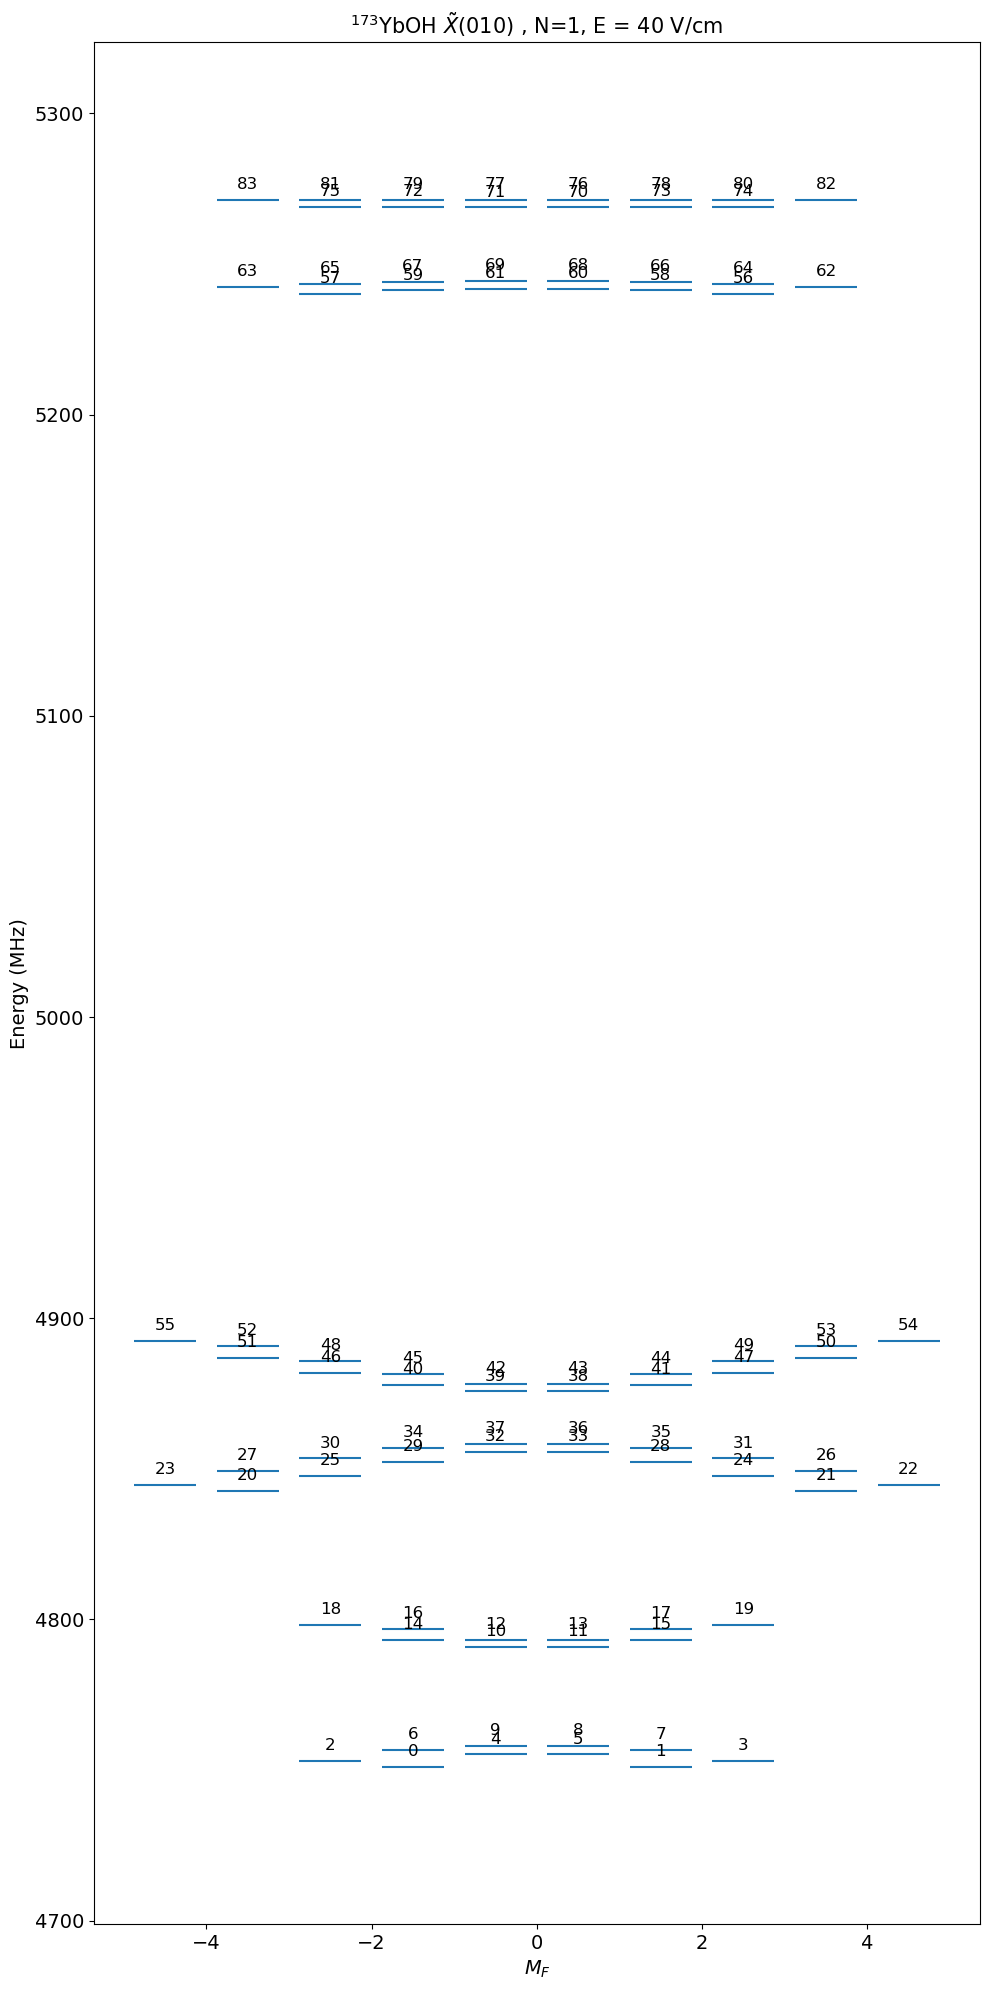

In [6]:
Efield = 40
X010_173.display_PTV(Efield,1e-8,'all',step_B = 1e-4, step_E = 1e-2, idx = X010_173.select_q({'N':1, 'G':3}),round=4,figsize=(10,20),off = 0, scale2 = 1.2, plot_state_index = True, plot_CPV = False, plot_only_one_CPV = None, fontsize_for_values = 12)
plt.title(X010_173.state_str + ' , N=1, E = {} V/cm'.format(X010_173.E0),fontsize=15)
#plt.yticks(np.linspace(4700,5300,301))
#plt.ylim(5250,5300)
plt.tight_layout()
plt.show()
#plt.savefig('MQM_science_state_level_diagram_20230313_173_all_shifts_' + str(Efield) + 'Vcm.pdf')

In [7]:
def set_state_parameters(state, updates=None):
    if updates is None:
        updates = {}
    new_params = dict(state.parameters)
    new_params.update(updates)

    state.parameters = new_params
    state.library.parameters[state.iso_state] = new_params

    b = state.library.H_builders[state.iso_state]
    state.H_function, state.H_symbolic = b(
        state.q_numbers,
        params=new_params,
        M_values=state.M_values,
        precision=state.round,
    )

    state.eigensystem(0, 1e-8, order=True, method="torch", set_attr=True)
    state.generate_parities(state.evecs0)



def parameter_vector_to_dict(vector):
    return {name: value for name, value in zip(FIT_PARAMETER_NAMES, vector)}


def current_parameter_dict(state=None):
    source = state.parameters if state is not None else BASE_PARAMETERS
    return {name: source[name] for name in FIT_PARAMETER_NAMES}


def parameters_to_vector(params):
    return np.array([params[name] for name in FIT_PARAMETER_NAMES], dtype=float)

set_state_parameters(X010_173)
baseline_parameter_vector = parameters_to_vector(current_parameter_dict(X010_173))

In [8]:

# Frequency transform controls (matching the previous plotting convention)
FREQ_OFFSET = 0  # MHz
FREQ_SCALE = 1  # Divide by two for two-photon frequency conversion
FREQ_SHIFT = 0  # Additional shift applied after scaling


def model_frequency_transform(raw_freq):
    """Map raw transition frequency from the model to the experimental frequency axis."""
    return (raw_freq - FREQ_OFFSET) * FREQ_SCALE + FREQ_SHIFT


# indices 38–55 and 70–83 (inclusive)
TRANSITION_INDEX_SET = list(range(38, 56)) + list(range(70, 84))
print(TRANSITION_INDEX_SET)
LASER_POLARIZATION = "both"
PARITY_SIGN = 1
INTENSITY_THRESHOLD = None  # Set to a float to discard transitions with weaker intensity
EZ_FIELD = 0  # Update if the experimental conditions change
B_FIELD = 1e-8

[38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83]


In [9]:
def compute_model_transitions(
    state,
    Ez=EZ_FIELD,
    B=B_FIELD,
    indices=None,
    parity_sign=PARITY_SIGN,
    polarization=LASER_POLARIZATION,
    allowed_transitions=None,
):
    """
    Compute model transitions with optional state index filtering.
    
    Parameters:
    -----------
    allowed_transitions : list of tuples or None, optional
        Filter transitions to specific state index pairs.
        Format: [((lower_min, lower_max), (upper_min, upper_max)), ...]
        Example: [((46, 55), (76, 83)), ((38, 45), (70, 75))]
    """
    index_list = indices if indices is not None else TRANSITION_INDEX_SET
    if index_list is None:
        index_list = list(range(84))

    result = state.calculate_two_photon_spectrum(
        Ez,
        B,
        index_list,
        parity_sign=parity_sign,
        laser_polarization=polarization,
        allowed_transitions=allowed_transitions,
    )
    transitions = pd.DataFrame(result[1])

    if not transitions.empty:
        transitions["freq_model"] = transitions["freq"].apply(model_frequency_transform)
        if INTENSITY_THRESHOLD is not None:
            intensity_key = next(
                (key for key in ["intensity", "Intensity", "strength"] if key in transitions.columns),
                None,
            )
            if intensity_key is not None:
                transitions = transitions[transitions[intensity_key] >= INTENSITY_THRESHOLD].reset_index(drop=True)

    return transitions, result


def merge_predictions_with_experiment(predicted_df, experimental_df):
    if experimental_df.empty:
        predicted_df = predicted_df.copy()
        predicted_df["freq_obs"] = np.nan
        predicted_df["residual"] = np.nan
        predicted_df["weight"] = 1.0
        return predicted_df, pd.DataFrame(), predicted_df

    merge_cols = ["state index 0", "state index 1"]
    for col in ["M0", "M1"]:
        if col in experimental_df.columns and col in predicted_df.columns:
            merge_cols.append(col)

    merged = experimental_df.merge(predicted_df, how="left", on=merge_cols, suffixes=("_obs", "_model"))
    missing = merged[merged["freq_model"].isna()].copy()

    merged["freq_model"] = merged["freq_model"].astype(float)
    merged["residual"] = merged["freq_model"] - merged["freq_obs"]
    if "uncertainty" in merged.columns:
        weights = merged["uncertainty"].replace(0, np.nan).fillna(1.0)
    else:
        weights = pd.Series(1.0, index=merged.index)
    merged["weight"] = weights
    merged["weighted_residual"] = merged["residual"] / merged["weight"]

    matched = merged[merged["freq_model"].notna()].copy()
    return matched, missing, predicted_df


def summarize_fit(matched_df):
    if matched_df.empty:
        return {"rms": np.nan, "weighted_rms": np.nan, "n_points": 0}

    valid = np.isfinite(matched_df["residual"]) & np.isfinite(matched_df["weight"])
    if not valid.any():
        return {"rms": np.nan, "weighted_rms": np.nan, "n_points": 0}

    residuals = matched_df.loc[valid, "residual"].to_numpy()
    weights = matched_df.loc[valid, "weight"].to_numpy()
    rms = np.sqrt(np.mean(residuals**2))
    weighted_rms = np.sqrt(np.mean((residuals / weights) ** 2))
    return {"rms": rms, "weighted_rms": weighted_rms, "n_points": int(valid.sum())}

In [10]:
import importlib.util
from pathlib import Path

# ---------------------------
# Load molecule_parameters.py
# ---------------------------
MP_PATH = Path("molecule_parameters.py")  # if it's in the notebook folder
if not MP_PATH.exists():
    # if needed, point to your uploaded path or repo path:
    MP_PATH = Path("/mnt/data/molecule_parameters.py")

spec = importlib.util.spec_from_file_location("molecule_parameters", str(MP_PATH))
mp = importlib.util.module_from_spec(spec)
spec.loader.exec_module(mp)

# ---------------------------------------------------------
# Read the parameter MEANS for YbOH 173X010 (includes general)
# ---------------------------------------------------------
# This is the clean merged dict that your library likely expects:
params_173X010_mean = dict(mp.all_params["YbOH"]["173X010"])  # includes params_general
# alternatively: params_173X010_mean = {**mp.params_173X010, **mp.params_general}

# (Optional) apply these as the baseline parameters to your state
# Use only keys your state actually supports, to avoid KeyError downstream.
state_supported = set(current_parameter_dict(X010_173).keys())
params_173X010_mean_filtered = {k: v for k, v in params_173X010_mean.items() if k in state_supported}

set_state_parameters(X010_173, params_173X010_mean_filtered)

print("Loaded params for 173X010 (filtered to state):")
for k in sorted(params_173X010_mean_filtered.keys()):
    print(f"  {k:12s} = {params_173X010_mean_filtered[k]}")

# ---------------------------------------------------------
# Define / build UNCERTAINTIES (sigmas) -> you must supply these
# ---------------------------------------------------------
# Recommended: make a dict with 1-sigma uncertainties in the SAME UNITS as params.
# If you don't have them yet, start with fractional placeholders.
PARAM_SIGMA_173X010 = {
    # Fill these with your measured 1-sigma uncertainties (MHz etc.)
    # Examples (PLACEHOLDERS — replace with real numbers):
    "Be": 0.4,
    "Gamma_SR": 3,
    "Gamma_Prime": 4,
    "bFYb": 0.8,
    "cYb": 10,
    "e2Qq0": 27,
    "q_lD": 0.5,
    "p_lD": 5,
    "muE": 0.01,
    "muE": 0.01 * 0.503412,
    "g_S_eff": 0.02,
}

# Fractional fallback if sigma not provided:
FRACTIONAL_SIGMA_FALLBACK = {
    "Be": 1e-4,
    "Gamma_SR": 2e-2,
    "Gamma_Prime": 2e-2,
    "bFYb": 5e-3,
    "cYb": 5e-2,
    "e2Qq0": 1e-2,
    "q_lD": 5e-2,
    "p_lD": 5e-2,
    "muE": 5e-3,
    "g_S_eff": 5e-3,
}

# Build priors: PARAM_PRIORS[name] = (mean, sigma)
PARAM_PRIORS = {}
for k, mu in params_173X010_mean_filtered.items():
    if k in PARAM_SIGMA_173X010:
        sig = float(PARAM_SIGMA_173X010[k])
    else:
        frac = float(FRACTIONAL_SIGMA_FALLBACK.get(k, 0.05))  # default 5% if unknown
        sig = abs(float(mu)) * frac if float(mu) != 0 else frac
    if sig <= 0:
        continue
    PARAM_PRIORS[k] = (float(mu), float(sig))

print("\nBuilt PARAM_PRIORS (mean, sigma):")
for k in sorted(PARAM_PRIORS.keys()):
    mu, sig = PARAM_PRIORS[k]
    print(f"  {k:12s} : mu={mu:.6g}, sigma={sig:.6g}")


Loaded params for 173X010 (filtered to state):
  Be           = 7334.130786908366
  Gamma_Prime  = 14.233846113382
  Gamma_SR     = -87.18714159785
  bFH          = 4.07
  bFYb         = -1880.9665339648823
  cH           = 3.49
  cYb          = -92.159499306238
  e2Qq0        = -3321.672553941406
  g_S_eff      = 2.07
  muE          = 1.08736992
  p_lD         = 12.766362031472
  q_lD         = 12.494150479608

Built PARAM_PRIORS (mean, sigma):
  Be           : mu=7334.13, sigma=0.4
  Gamma_Prime  : mu=14.2338, sigma=4
  Gamma_SR     : mu=-87.1871, sigma=3
  bFH          : mu=4.07, sigma=0.2035
  bFYb         : mu=-1880.97, sigma=0.8
  cH           : mu=3.49, sigma=0.1745
  cYb          : mu=-92.1595, sigma=10
  e2Qq0        : mu=-3321.67, sigma=27
  g_S_eff      : mu=2.07, sigma=0.02
  muE          : mu=1.08737, sigma=0.00503412
  p_lD         : mu=12.7664, sigma=5
  q_lD         : mu=12.4942, sigma=0.5


In [11]:
import numpy as np
import pandas as pd
from pathlib import Path


# -----------------------------
# Unassigned multi-spectrum data loading
# -----------------------------
UNASSIGNED_DATA_PATH = Path("synthetic_peaks.csv")  # or your real CSV
UNASSIGNED_SIGMA = 0.15  # MHz Gaussian broadening (150 kHz) used in loss and plotting

# Fallback defaults ONLY used if you call the model without Ez/B explicitly
DEFAULT_EZ_FIELD = 40.0
DEFAULT_B_FIELD = 1e-8

# Load peak-list data (must contain these columns)
dfu = pd.read_csv(UNASSIGNED_DATA_PATH)
required = ["spectrum_id", "Ez_V_per_cm", "Bz_G", "nu_obs_MHz"]
missing = [c for c in required if c not in dfu.columns]
if missing:
    raise ValueError(f"Unassigned spectrum CSV missing columns: {missing}")

dfu["nu_obs_MHz"] = pd.to_numeric(dfu["nu_obs_MHz"], errors="coerce")
dfu = dfu.dropna(subset=["nu_obs_MHz"]).reset_index(drop=True)

OBS_SPECTRA = []
for sid, g in dfu.groupby("spectrum_id", sort=False):
    Ez = float(g["Ez_V_per_cm"].iloc[0])
    Bz = float(g["Bz_G"].iloc[0])
    freqs = np.sort(g["nu_obs_MHz"].to_numpy(dtype=float))
    OBS_SPECTRA.append({"id": sid, "Ez": Ez, "B": Bz, "freqs": freqs})

print("Loaded spectra:", [(s["id"], len(s["freqs"]), s["Ez"], s["B"]) for s in OBS_SPECTRA])


# -----------------------------
# Unassigned spectrum comparison machinery
# -----------------------------
def gaussian_broadened_spectrum(frequencies, weights=None, freq_axis=None, sigma=UNASSIGNED_SIGMA):
    frequencies = np.asarray(frequencies, float)
    if weights is None:
        weights = np.ones_like(frequencies)
    else:
        weights = np.asarray(weights, float)

    if freq_axis is None:
        if frequencies.size == 0:
            return np.linspace(0, 1, 1000), np.zeros(1000)
        f_min = frequencies.min() - 3 * sigma
        f_max = frequencies.max() + 3 * sigma
        freq_axis = np.linspace(f_min, f_max, 2000)

    if frequencies.size == 0:
        return freq_axis, np.zeros_like(freq_axis)

    diff = freq_axis[:, None] - frequencies[None, :]
    spec = np.exp(-(diff**2) / (2 * sigma**2)) @ weights
    return freq_axis, spec


def spectral_residual(predicted_freqs, observed_freqs, predicted_weights=None, observed_weights=None, sigma=UNASSIGNED_SIGMA):
    """
    Compare two unassigned peak lists by converting each into a Gaussian-broadened "spectrum"
    on a shared frequency axis and computing RMS difference.
    """
    predicted_freqs = np.asarray(predicted_freqs, float)
    observed_freqs = np.asarray(observed_freqs, float)

    # Choose a shared axis covering both
    if predicted_freqs.size == 0 and observed_freqs.size == 0:
        return 0.0
    if predicted_freqs.size == 0:
        fmin, fmax = observed_freqs.min(), observed_freqs.max()
    elif observed_freqs.size == 0:
        fmin, fmax = predicted_freqs.min(), predicted_freqs.max()
    else:
        fmin = min(predicted_freqs.min(), observed_freqs.min())
        fmax = max(predicted_freqs.max(), observed_freqs.max())

    axis = np.linspace(fmin - 3*sigma, fmax + 3*sigma, 2000)

    _, pred_spec = gaussian_broadened_spectrum(predicted_freqs, weights=predicted_weights, freq_axis=axis, sigma=sigma)
    _, obs_spec  = gaussian_broadened_spectrum(observed_freqs,  weights=observed_weights,  freq_axis=axis, sigma=sigma)

    # Normalize to make this mostly "shape/position" not "count of peaks"
    pred_spec = pred_spec / (pred_spec.max() if pred_spec.max() else 1.0)
    obs_spec  = obs_spec  / (obs_spec.max()  if obs_spec.max()  else 1.0)

    return float(np.sqrt(np.mean((pred_spec - obs_spec)**2)))


def transition_frequency_set(state, Ez=None, B=None, indices=None, **kwargs):
    """
    Returns predicted transition frequencies and weights for a given (Ez,B).
    FIX: no default args referencing EZ_FIELD/B_FIELD -> avoids NameError.
    """
    if Ez is None:
        Ez = DEFAULT_EZ_FIELD
    if B is None:
        B = DEFAULT_B_FIELD

    transitions, raw = compute_model_transitions(state, Ez=Ez, B=B, indices=indices, **kwargs)
    if transitions is None or transitions.empty:
        return np.array([]), np.array([]), raw

    # Try to pull an intensity/strength column if present
    weights = None
    for candidate in ["intensity", "Intensity", "strength", "Strength"]:
        if candidate in transitions.columns:
            weights = transitions[candidate].to_numpy(dtype=float)
            break

    freqs = transitions["freq_model"].to_numpy(dtype=float) if "freq_model" in transitions.columns else np.array([], float)
    if weights is None:
        weights = np.ones_like(freqs)

    return freqs, weights, raw


def unassigned_multispectrum_loss(state, spectra, indices=None, sigma=UNASSIGNED_SIGMA, **kwargs):
    """
    Average loss over many spectra, each with its own Ez/B.
    """
    losses = []
    for s in spectra:
        pred_f, pred_w, _ = transition_frequency_set(state, Ez=s["Ez"], B=s["B"], indices=indices, **kwargs)
        loss = spectral_residual(pred_f, s["freqs"], predicted_weights=pred_w, observed_weights=None, sigma=sigma)
        losses.append(loss)

    return float(np.mean(losses)) if losses else np.inf

Loaded spectra: [('spec0', 9, 0.0, 0.0), ('spec1', 7, 10.0, 0.0), ('spec2', 7, 20.0, 0.0), ('spec3', 6, 40.0, 0.0)]


In [12]:
# ============================================================================
# EXPERIMENTAL CONSTRAINTS: Allowed State Index Pairs
# ============================================================================
# Define experimentally-constrained transitions:
# - Transitions between states 46-55 and states 76-83
# - Transitions between states 38-45 and states 70-75

ALLOWED_TRANSITIONS = [
    ((46, 55), (76, 83)),  # First set of allowed transitions
    ((38, 45), (70, 75)),  # Second set of allowed transitions
]

print("Experimental constraints loaded:")
print(f"  - Transitions between states 46-55 ↔ 76-83")
print(f"  - Transitions between states 38-45 ↔ 70-75")
print(f"\nTo use these constraints, pass allowed_transitions=ALLOWED_TRANSITIONS")
print(f"to compute_model_transitions() or related functions.")
print(f"\nTo disable filtering (compute all transitions), use allowed_transitions=None")

Experimental constraints loaded:
  - Transitions between states 46-55 ↔ 76-83
  - Transitions between states 38-45 ↔ 70-75

To use these constraints, pass allowed_transitions=ALLOWED_TRANSITIONS
to compute_model_transitions() or related functions.

To disable filtering (compute all transitions), use allowed_transitions=None


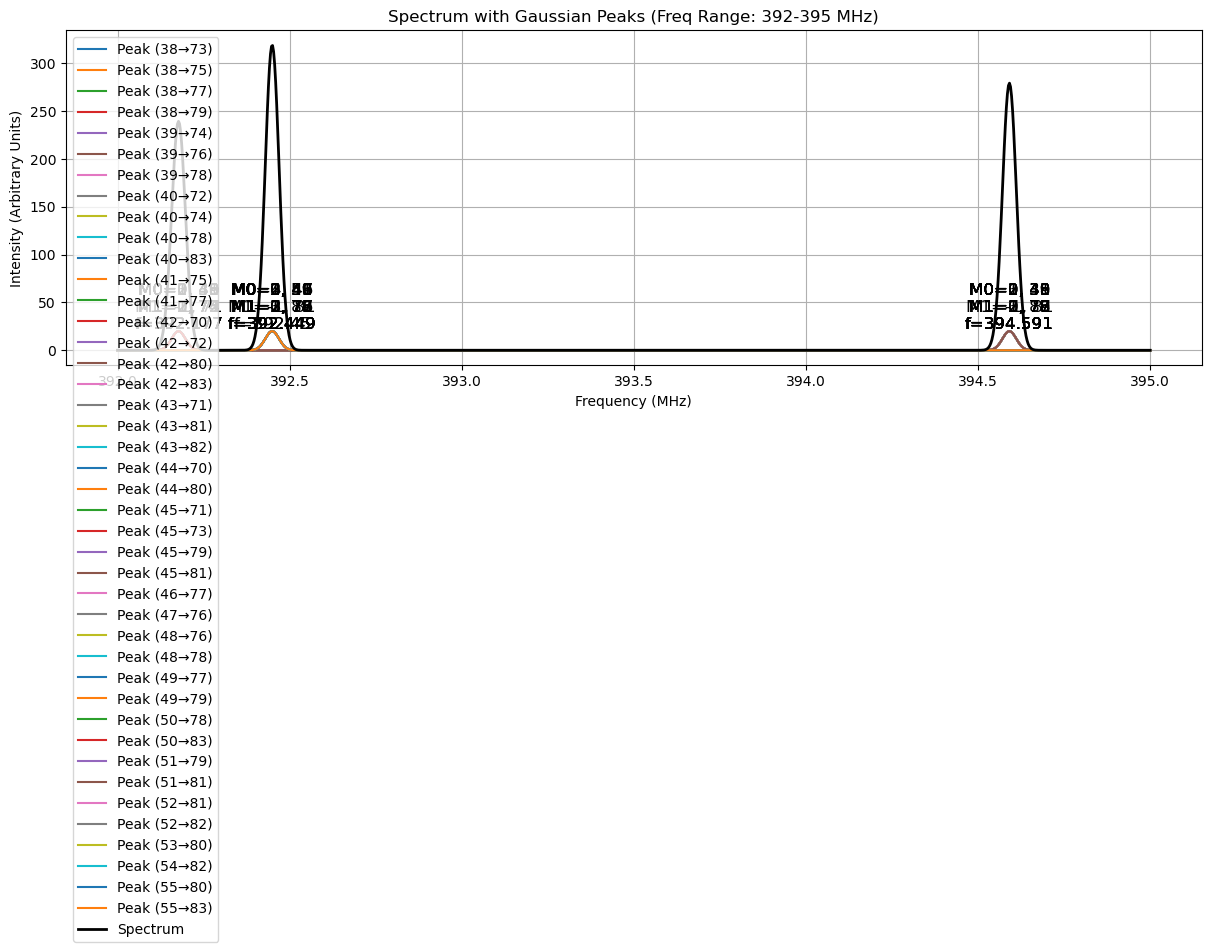

In [13]:
out = X010_173.calculate_two_photon_spectrum(0, 1e-8,list(range(84)), parity_sign = 1, laser_polarization = 'orth')

transitions = out[1]

# Frequency bounds (AOM 0 frequency)
freq_min = 392
freq_max = 395

offset  = 0 # MHz

# Filter transitions within bounds
filtered_transitions = [t for t in transitions if (freq_min <= (t['freq']-offset) <= freq_max)]  


# Spectrum parameters
freq_range = np.linspace(freq_min, freq_max, 1000)  # Define the frequency range for the plot
freq_width = 0.02 # Gaussian width in MHz

# Initialize the spectrum
spectrum = np.zeros_like(freq_range)

# Create figure with constrained layout
fig, ax = plt.subplots(figsize=(12, 8), constrained_layout=True)

for transition in filtered_transitions:
    freq = (transition['freq']- offset)   #accounting for 1 MHz offset correction
    label = f"({transition['state index 0']}→{transition['state index 1']})"
    
    # Generate Gaussian peak
    gaussian_peak = norm.pdf(freq_range, loc=freq, scale=freq_width)
    spectrum += gaussian_peak  # Add the peak to the spectrum
    
    # Plot the peak
    ax.plot(freq_range, gaussian_peak, label=f"Peak {label}")
    
    
    # Annotate the peak with state information
    if transition['M0'] >= 0:
        ax.text(freq, max(gaussian_peak) * 1.1, f"M0={transition['M0']}, {transition['state index 0']}\nM1={transition['M1']}, {transition['state index 1']}\nf={round(freq,3)}",
            fontsize=12, ha='center')
    
# Plot the combined spectrum
ax.plot(freq_range, spectrum, color='black', linewidth=2, label='Spectrum')

# Labels and title
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Intensity (Arbitrary Units)')
ax.set_title(f'Spectrum with Gaussian Peaks (Freq Range: {freq_min}-{freq_max} MHz)')
ax.grid(True)
ax.legend()

# Show the plot
plt.show()


In [14]:
import numpy as np
import pandas as pd

# -------------------------
# Choose which parameters to vary (start SMALL for sparse data)
# -------------------------
SEARCH_PARAM_NAMES = [
    "Be", "Gamma_SR", "Gamma_Prime", "bFYb", "cYb", "e2Qq0", "q_lD", "p_lD", "muE", "g_S_eff"
]
SEARCH_PARAM_NAMES = [p for p in SEARCH_PARAM_NAMES if p in PARAM_PRIORS]

# How far you allow the search to move from the measured value
NSIGMA_BOX = 3.0           # hard truncation box from priors
NSIGMA_SAMPLE = 2.0        # typical samples (still clipped by NSIGMA_BOX)
LAMBDA_PRIOR = 0.05        # strength of prior penalty (tune 0.01–1)

def build_bounds_from_priors(priors, names, nsigma=3.0, hard_bounds=None):
    """
    bounds[name] = (low, high) derived from mu±nsigma*sigma,
    optionally intersected with hard_bounds (like FIT_PARAMETER_BOUNDS).
    """
    b = {}
    for k in names:
        mu, sig = priors[k]
        lo, hi = float(mu - nsigma*sig), float(mu + nsigma*sig)
        if hard_bounds is not None and k in hard_bounds:
            hlo, hhi = hard_bounds[k]
            lo, hi = max(lo, float(hlo)), min(hi, float(hhi))
        if not np.isfinite(lo) or not np.isfinite(hi) or lo >= hi:
            # fall back to something reasonable
            lo, hi = float(mu - nsigma*sig), float(mu + nsigma*sig)
        b[k] = (lo, hi)
    return b

def prior_penalty(updates, priors):
    """Σ ((p-mu)/sigma)^2 over keys in updates that have priors."""
    s = 0.0
    for k, v in updates.items():
        if k not in priors:
            continue
        mu, sig = priors[k]
        sig = float(sig)
        if sig <= 0:
            continue
        z = (float(v) - float(mu)) / sig
        s += z*z
    return float(s)

def sample_from_priors(priors, bounds, rng, nsigma=2.0):
    """
    Sample each parameter from N(mu, sigma) but clip to bounds.
    """
    upd = {}
    for k, (lo, hi) in bounds.items():
        mu, sig = priors[k]
        mu, sig = float(mu), float(sig)
        if sig <= 0:
            x = mu
        else:
            z = rng.normal(0.0, 1.0)
            z = np.clip(z, -nsigma, nsigma)
            x = mu + sig*z
        # clip to hard bounds box
        x = float(np.clip(x, lo, hi))
        upd[k] = x
    return upd

def apply_params_partial(state, updates):
    """Update only a subset of params; keep the rest unchanged."""
    cur = current_parameter_dict(state)
    cur.update(updates)
    set_state_parameters(state, cur)

def total_loss_MAP(state, spectra, updates, priors,
                   indices=None, sigma=UNASSIGNED_SIGMA,
                   parity_sign=None, polarization=None,
                   lambda_prior=LAMBDA_PRIOR,
                   allowed_transitions=None):
    """
    L_total = L_data + lambda_prior * prior_penalty
    """
    apply_params_partial(state, updates)

    L_data = unassigned_multispectrum_loss(
        state, spectra,
        indices=indices,
        sigma=sigma,
        parity_sign=parity_sign,
        polarization=polarization,
        allowed_transitions=allowed_transitions,
    )

    L_prior = prior_penalty(updates, priors)
    return float(L_data + lambda_prior * L_prior), float(L_data), float(L_prior)

# Construct bounds (use FIT_PARAMETER_BOUNDS if you have it)
try:
    HARD_BOUNDS = FIT_PARAMETER_BOUNDS
except NameError:
    HARD_BOUNDS = None

SEARCH_BOUNDS = build_bounds_from_priors(PARAM_PRIORS, SEARCH_PARAM_NAMES, nsigma=NSIGMA_BOX, hard_bounds=HARD_BOUNDS)
SEARCH_BOUNDS


{'Be': (7332.930786908366, 7335.330786908366),
 'Gamma_SR': (-96.18714159785, -78.18714159785),
 'Gamma_Prime': (11.3870768907056, 17.0806153360584),
 'bFYb': (-1883.3665339648824, -1878.5665339648822),
 'cYb': (-110.5913991674856, -73.7275994449904),
 'e2Qq0': (-3402.672553941406, -3240.672553941406),
 'q_lD': (10.994150479608, 13.994150479608),
 'p_lD': (10.213089625177599, 15.3196344377664),
 'muE': (1.07226756, 1.10247228),
 'g_S_eff': (2.01, 2.13)}

In [15]:
def search_candidates_MAP(state, spectra, priors, bounds,
                          n_samples=2000, top_k=30,
                          refine_steps=150, refine_scale=0.35,
                          indices=None, sigma=UNASSIGNED_SIGMA,
                          parity_sign=None, polarization=None,
                          lambda_prior=LAMBDA_PRIOR,
                          allowed_transitions=None,
                          seed=0, verbose=True):
    """
    Stage 1: sample many candidates from priors, keep top_k.
    Stage 2: for each top candidate, do a cheap local random-walk refinement inside bounds.
    Returns a dataframe sorted by total_loss.
    
    Parameters:
    -----------
    allowed_transitions : list of tuples or None
        Optional experimental constraints on state index pairs.
    """
    rng = np.random.default_rng(seed)

    # ---- Stage 1: coarse prior sampling
    coarse = []
    for i in range(int(n_samples)):
        upd = sample_from_priors(priors, bounds, rng, nsigma=NSIGMA_SAMPLE)
        Ltot, Ldata, Lprior = total_loss_MAP(
            state, spectra, upd, priors,
            indices=indices, sigma=sigma,
            parity_sign=parity_sign, polarization=polarization,
            lambda_prior=lambda_prior,
            allowed_transitions=allowed_transitions,
        )
        coarse.append({"loss_total": Ltot, "loss_data": Ldata, "loss_prior": Lprior, **upd})

    coarse.sort(key=lambda d: d["loss_total"])
    keep = coarse[:int(top_k)]

    if verbose:
        print(f"Coarse done: sampled {n_samples}, keeping top {top_k}. Best total={keep[0]['loss_total']:.5g} data={keep[0]['loss_data']:.5g}")

    # ---- Stage 2: refine each candidate by small proposals (random-walk)
    refined = []
    for j, cand in enumerate(keep):
        base = {k: cand[k] for k in bounds.keys()}
        best = dict(base)
        best_Ltot, best_Ldata, best_Lprior = total_loss_MAP(
            state, spectra, best, priors,
            indices=indices, sigma=sigma,
            parity_sign=parity_sign, polarization=polarization,
            lambda_prior=lambda_prior,
            allowed_transitions=allowed_transitions,
        )

        for t in range(int(refine_steps)):
            prop = dict(best)
            # propose perturbations scaled by sigma and refine_scale
            for k, (lo, hi) in bounds.items():
                mu, sig = priors[k]
                step = float(sig) * refine_scale
                if step <= 0:
                    continue
                prop[k] = float(np.clip(prop[k] + rng.normal(0.0, step), lo, hi))

            Ltot, Ldata, Lprior = total_loss_MAP(
                state, spectra, prop, priors,
                indices=indices, sigma=sigma,
                parity_sign=parity_sign, polarization=polarization,
                lambda_prior=lambda_prior,
                allowed_transitions=allowed_transitions,
            )

            if Ltot < best_Ltot:
                best, best_Ltot, best_Ldata, best_Lprior = prop, Ltot, Ldata, Lprior

        refined.append({"loss_total": best_Ltot, "loss_data": best_Ldata, "loss_prior": best_Lprior, **best})

        if verbose:
            print(f"Refine {j+1}/{len(keep)}: best total={best_Ltot:.5g} data={best_Ldata:.5g} prior={best_Lprior:.3g}")

    df = pd.DataFrame(refined).sort_values("loss_total").reset_index(drop=True)
    return df

# ---- RUN SEARCH ----
best_df = search_candidates_MAP(
    X010_173,
    OBS_SPECTRA,
    priors={k: PARAM_PRIORS[k] for k in SEARCH_BOUNDS.keys()},
    bounds=SEARCH_BOUNDS,
    n_samples=20,        # 20–100 for smoke test
    top_k=5,             # keep small
    refine_steps=10,     # 0–20
    refine_scale=0.20,   # smaller steps since few steps
    indices=None,
    sigma=UNASSIGNED_SIGMA,
    parity_sign=PARITY_SIGN,
    polarization=LASER_POLARIZATION,
    lambda_prior=LAMBDA_PRIOR,
    allowed_transitions=None,  # Set to ALLOWED_TRANSITIONS to use experimental constraints
    seed=123,
    verbose=True,
)



best_df.head(10)


Coarse done: sampled 20, keeping top 5. Best total=0.19396 data=0.079683
Refine 1/5: best total=0.1403 data=0.079989 prior=1.21
Refine 2/5: best total=0.13429 data=0.081026 prior=1.07
Refine 3/5: best total=0.16085 data=0.08213 prior=1.57
Refine 4/5: best total=0.14046 data=0.079717 prior=1.21
Refine 5/5: best total=0.22746 data=0.082771 prior=2.89


,loss_total,loss_data,loss_prior,Be,Gamma_SR,Gamma_Prime,bFYb,cYb,e2Qq0,q_lD,p_lD,muE,g_S_eff
0,0.134291,0.081026,1.065294,7333.969090,-85.771759,15.887715,-1880.885785,-89.524007,-3305.574540,12.433392,13.877261,1.087475,2.071860
1,0.140304,0.079989,1.206311,7334.021737,-88.377493,13.205308,-1880.698795,-99.690078,-3315.510564,12.297435,12.039750,1.087483,2.070578
2,0.140463,0.079717,1.214918,7333.872697,-87.129875,15.981156,-1880.964294,-94.238053,-3311.572323,12.620439,11.128230,1.085776,2.062181
3,0.160849,0.082130,1.574386,7333.938534,-88.117527,13.568129,-1880.960883,-96.985350,-3332.418816,12.173142,11.698709,1.088390,2.081477
4,0.227465,0.082771,2.893866,7333.946778,-88.666638,17.080615,-1880.715728,-82.757557,-3301.482611,12.404824,14.047780,1.085665,2.061542



Transitions for spectrum spec0 in window 300.0-400.0 MHz (showing up to 12):
 freq_model  state index 0  state index 1
 389.020508             38             74
 389.020508             38             75
 391.434570             38             76
 391.435547             38             82
 391.435547             38             83
 389.020508             39             73
 389.020508             39             74
 389.020508             39             75
 391.434570             39             76
 391.434570             39             77
 391.435547             39             82
 391.435547             39             83

Transitions for spectrum spec1 in window 300.0-400.0 MHz (showing up to 12):
 freq_model  state index 0  state index 1
 389.059570             38             70
 389.061523             38             71
 389.065918             38             72
 389.066895             38             73
 389.069336             38             74
 391.474121             38             76
 391

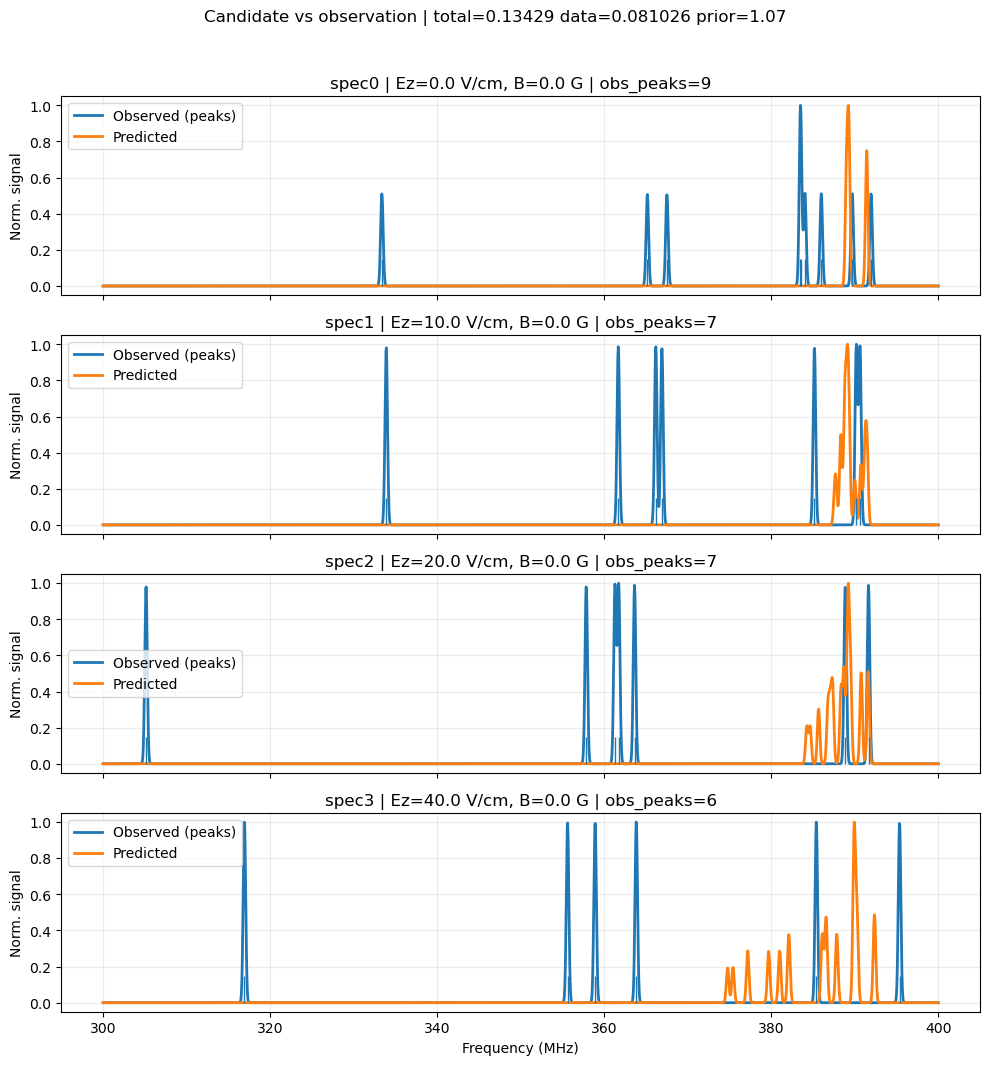


Transitions for spectrum spec0 in window 300.0-400.0 MHz (showing up to 12):
 freq_model  state index 0  state index 1
 394.648438             38             70
 394.648438             38             71
 394.648438             38             72
 397.062988             38             78
 397.062988             38             79
 397.062988             38             80
 397.062988             38             81
 394.648438             39             73
 394.648438             39             74
 397.062988             39             76
 397.063965             39             82
 397.063965             39             83

Transitions for spectrum spec1 in window 300.0-400.0 MHz (showing up to 12):
 freq_model  state index 0  state index 1
 394.687500             38             70
 394.688477             38             71
 394.689941             38             72
 394.689941             38             73
 394.698730             38             74
 397.099121             38             76
 397

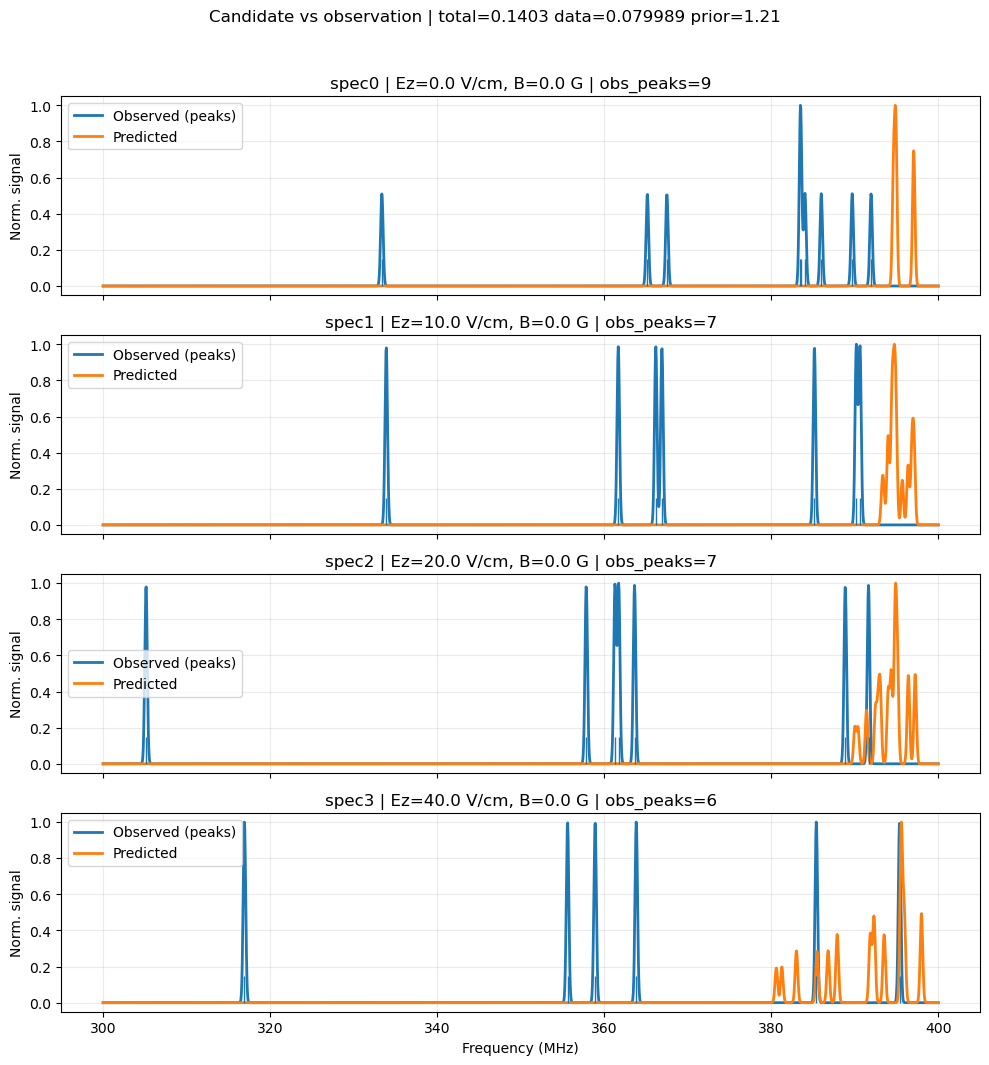


Transitions for spectrum spec0 in window 300.0-400.0 MHz (showing up to 12):
 freq_model  state index 0  state index 1
 390.728027             38             70
 390.728027             38             73
 390.728027             38             74
 390.728027             38             75
 393.142578             38             76
 393.142578             38             77
 393.144531             38             78
 393.144531             38             79
 393.144531             38             80
 390.728027             39             70
 390.728027             39             72
 390.728027             39             73

Transitions for spectrum spec1 in window 300.0-400.0 MHz (showing up to 12):
 freq_model  state index 0  state index 1
 390.769043             38             70
 390.771484             38             71
 390.773438             38             72
 390.773438             38             73
 390.783691             38             75
 393.183105             38             76
 393

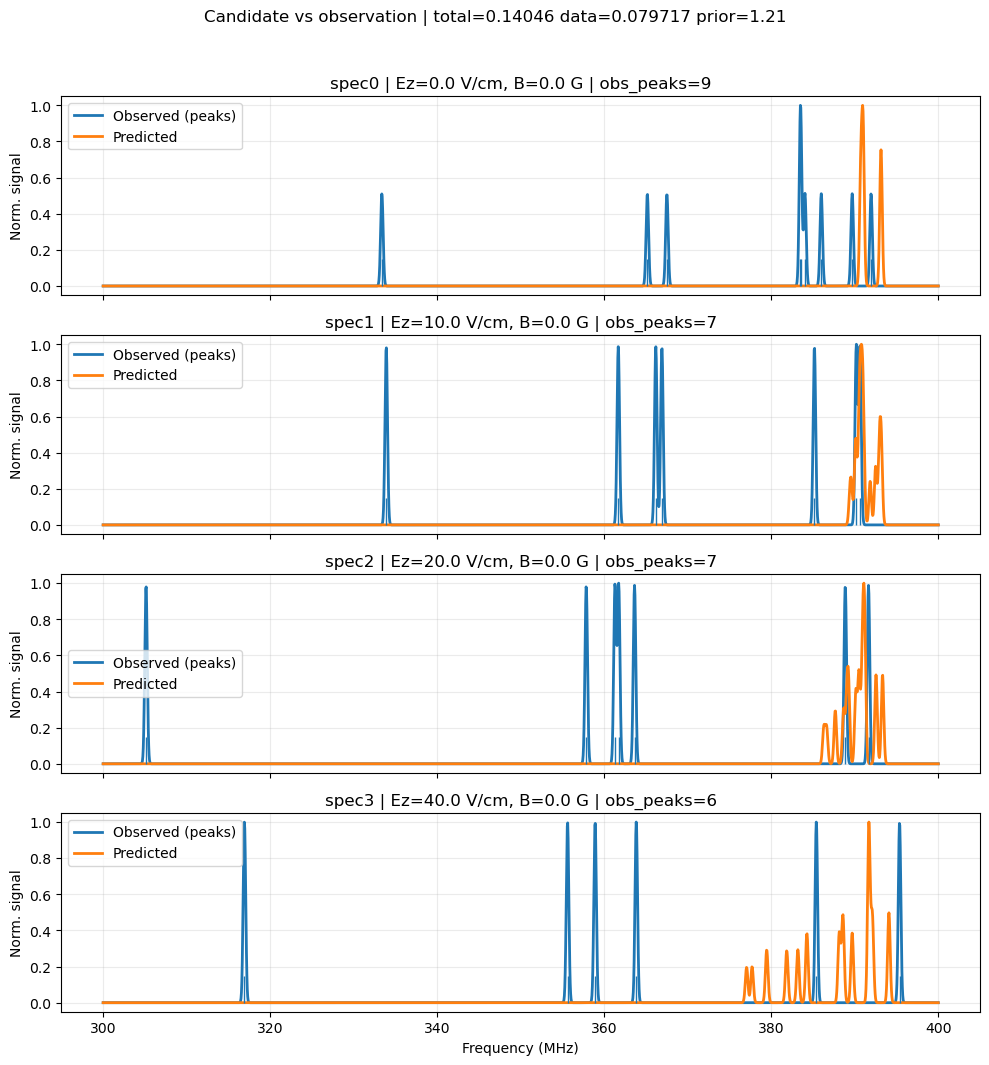


Transitions for spectrum spec0 in window 300.0-400.0 MHz (showing up to 12):
 freq_model  state index 0  state index 1
 395.093750             38             74
 395.093750             38             75
 397.507812             38             76
 397.509766             38             82
 397.509766             38             83
 395.093750             39             73
 395.093750             39             74
 395.093750             39             75
 397.507812             39             76
 397.507812             39             77
 397.509766             39             82
 397.509766             39             83

Transitions for spectrum spec1 in window 300.0-400.0 MHz (showing up to 12):
 freq_model  state index 0  state index 1
 395.129395             38             70
 395.131836             38             71
 395.133789             38             72
 395.134766             38             73
 395.144043             38             74
 397.543457             38             76
 397

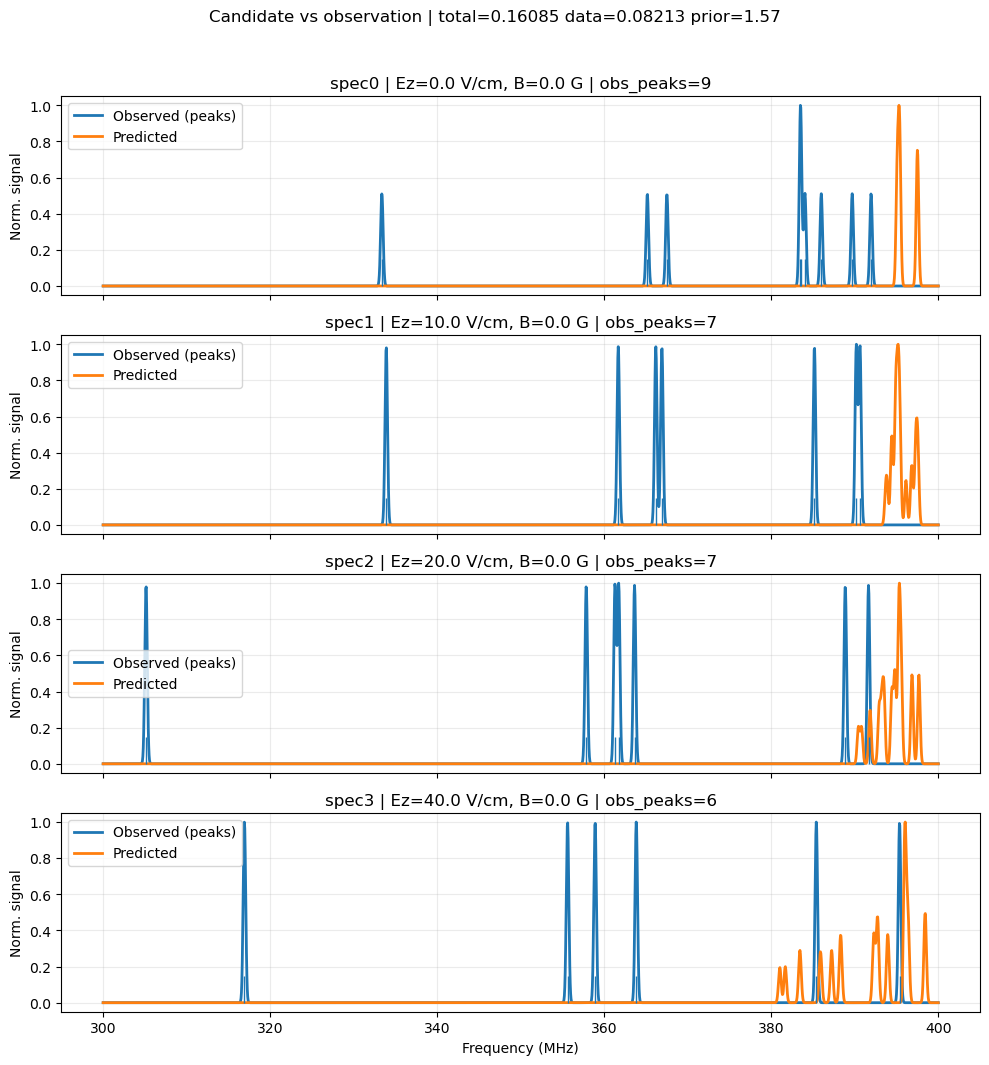


Transitions for spectrum spec0 in window 300.0-400.0 MHz (showing up to 12):
 freq_model  state index 0  state index 1
 386.784180             38             72
 386.784180             38             73
 386.784180             38             74
 386.784180             38             75
 389.196289             38             76
 389.196289             38             77
 389.196289             38             78
 389.198242             38             82
 389.198242             38             83
 386.784180             39             70
 386.784180             39             72
 386.784180             39             73

Transitions for spectrum spec1 in window 300.0-400.0 MHz (showing up to 12):
 freq_model  state index 0  state index 1
 386.821289             38             70
 386.822754             38             71
 386.823242             38             72
 386.824707             38             73
 386.830566             38             74
 389.234375             38             76
 389

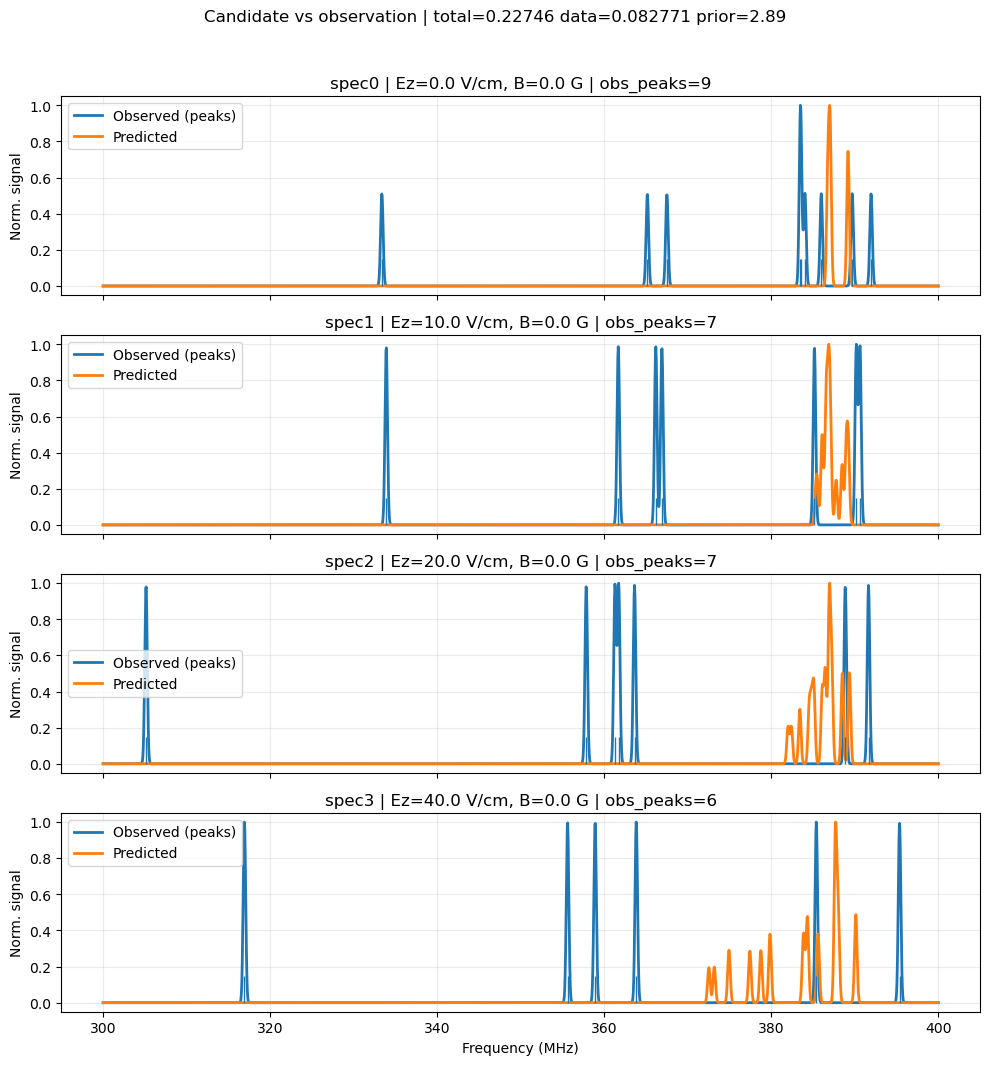

In [16]:
import matplotlib.pyplot as plt

def gaussian_broadened_spectrum(freqs, weights, axis, sigma):
    freqs = np.asarray(freqs, float)
    if weights is None:
        weights = np.ones_like(freqs, float)
    weights = np.asarray(weights, float)
    if freqs.size == 0:
        return np.zeros_like(axis, float)
    diff = axis[:, None] - freqs[None, :]
    return np.exp(-(diff**2) / (2.0 * sigma**2)) @ weights

def transition_frequency_set_safe(state, Ez, B, indices=None, parity_sign=None, polarization=None, 
                                   allowed_transitions=None, return_transitions=False):
    if parity_sign is None: parity_sign = PARITY_SIGN
    if polarization is None: polarization = LASER_POLARIZATION

    transitions, _raw = compute_model_transitions(
        state, Ez=Ez, B=B, indices=indices,
        parity_sign=parity_sign, polarization=polarization,
        allowed_transitions=allowed_transitions
    )
    if transitions is None or transitions.empty or "freq_model" not in transitions.columns:
        if return_transitions:
            return np.array([], float), np.array([], float), transitions
        return np.array([], float), np.array([], float)

    freqs = transitions["freq_model"].to_numpy(dtype=float)

    w = None
    for cand in ["intensity", "Intensity", "strength", "Strength"]:
        if cand in transitions.columns:
            w = transitions[cand].to_numpy(dtype=float)
            break
    if w is None:
        w = np.ones_like(freqs, float)

    if return_transitions:
        return freqs, w, transitions
    return freqs, w

def _select_transition_columns(df):
    # Prioritize frequency/intensity plus any upper_/lower_ quantum-number columns
    base = ["freq_model", "intensity", "Intensity", "strength", "Strength"]
    quantum_cols = [c for c in df.columns if "upper_" in c.lower() or "lower_" in c.lower() or "state" in c.lower()]
    # Keep order: base then quantum cols (unique, preserve appearance)
    seen = set()
    cols = []
    for c in base + quantum_cols:
        if c in df.columns and c not in seen:
            cols.append(c)
            seen.add(c)
    if not cols:
        cols = list(df.columns[: min(12, len(df.columns))])
    return cols

def plot_candidate(state, candidate_dict, spectra, window=(300.0, 400.0),
                   indices=None, sigma=UNASSIGNED_SIGMA,
                   parity_sign=None, polarization=None,
                   allowed_transitions=None,
                   title_extra="", savepath=None,
                   show_transitions=True, max_transitions=12):
    """
    Plot candidate parameters against observed spectra.
    
    Parameters:
    -----------
    allowed_transitions : list of tuples or None
        Optional experimental constraints on state index pairs.
    """
    cand = dict(candidate_dict)
    loss_total = cand.pop("loss_total", None)
    loss_data  = cand.pop("loss_data", None)
    loss_prior = cand.pop("loss_prior", None)

    apply_params_partial(state, cand)

    n = len(spectra)
    fig, axes = plt.subplots(n, 1, figsize=(10, 2.6*n), sharex=True)
    if n == 1:
        axes = [axes]

    fmin, fmax = window
    axis = np.linspace(fmin, fmax, 2000)

    for ax, s in zip(axes, spectra):
        obs = np.asarray(s["freqs"], float)
        pred_f, pred_w, trans_df = transition_frequency_set_safe(
            state, Ez=s["Ez"], B=s["B"], indices=indices,
            parity_sign=parity_sign, polarization=polarization,
            allowed_transitions=allowed_transitions,
            return_transitions=True,
        )

        # keep only plotting window
        obs_w = obs[(obs >= fmin) & (obs <= fmax)]
        pred_mask = (pred_f >= fmin) & (pred_f <= fmax)
        pred_f_w = pred_f[pred_mask]
        pred_w_w = pred_w[pred_mask] if pred_w is not None else None

        obs_spec  = gaussian_broadened_spectrum(obs_w, np.ones_like(obs_w), axis, sigma)
        pred_spec = gaussian_broadened_spectrum(pred_f_w, pred_w_w, axis, sigma)

        obs_spec  = obs_spec  / (obs_spec.max()  if obs_spec.max()  else 1.0)
        pred_spec = pred_spec / (pred_spec.max() if pred_spec.max() else 1.0)

        ax.plot(axis, obs_spec, label="Observed (peaks)", linewidth=2)
        ax.plot(axis, pred_spec, label="Predicted", linewidth=2)

        if obs_w.size:
            ax.vlines(obs_w, 0, 0.15, linewidth=1)

        ax.set_ylabel("Norm. signal")
        ax.set_title(f"{s['id']} | Ez={s['Ez']} V/cm, B={s['B']} G | obs_peaks={obs_w.size}")

        ax.grid(True, alpha=0.25)
        ax.legend()

        if show_transitions and trans_df is not None and not trans_df.empty:
            # Align transitions to the window mask when possible
            if len(trans_df) == len(pred_f):
                trans_window = trans_df[pred_mask]
            else:
                trans_window = trans_df[(trans_df.get("freq_model", 0) >= fmin) & (trans_df.get("freq_model", 0) <= fmax)]
            cols = _select_transition_columns(trans_window)
            preview = trans_window[cols].head(max_transitions)
            print(f"\nTransitions for spectrum {s['id']} in window {fmin}-{fmax} MHz (showing up to {max_transitions}):")
            print(preview.to_string(index=False))

    axes[-1].set_xlabel("Frequency (MHz)")
    supt = "Candidate vs observation"
    if loss_total is not None:
        supt += f" | total={loss_total:.5g} data={loss_data:.5g} prior={loss_prior:.3g}"
    if title_extra:
        supt += " | " + title_extra
    fig.suptitle(supt, y=1.02)
    fig.tight_layout()

    if savepath is not None:
        fig.savefig(savepath, dpi=200, bbox_inches="tight")
        print("saved:", savepath)

    plt.show()

# ---- plot top N candidates ----
TOP_PLOT = 10
for i in range(min(TOP_PLOT, len(best_df))):
    cand = best_df.iloc[i].to_dict()
    plot_candidate(
        X010_173, cand, OBS_SPECTRA,
        window=(300.0, 400.0),   # your scan window
        indices=None,
        sigma=UNASSIGNED_SIGMA,
        parity_sign=PARITY_SIGN,
        polarization=LASER_POLARIZATION,
        allowed_transitions=None,  # Set to ALLOWED_TRANSITIONS to use experimental constraints
        savepath=f"cand_{i:02d}.png",
    )

In [ ]:
# GPU Profiling after fitting pipeline
print_gpu_profile_checkpoint("After Parameter Search & Fitting Pipeline")

In [ ]:
# ============================================================================
# DEMONSTRATION: Using Experimental Transition Constraints
# ============================================================================
# Example 1: Compute transitions with experimental constraints
print("Example 1: Compute transitions WITH experimental constraints")
print("=" * 70)

transitions_constrained, _ = compute_model_transitions(
    X010_173,
    Ez=0,
    B=1e-8,
    indices=None,  # or list(range(84))
    allowed_transitions=ALLOWED_TRANSITIONS
)

print(f"Number of transitions found (constrained): {len(transitions_constrained)}")
if not transitions_constrained.empty:
    print("\nFirst few transitions:")
    print(transitions_constrained[['state index 0','state index 1','freq_model']].to_string(index=False))
print("\n" + "=" * 70)
print("Example 2: Compute ALL transitions (no constraints)")
print("=" * 70)

transitions_all, _ = compute_model_transitions(
    X010_173,
    Ez=0,
    B=1e-8,
    indices=None,
    allowed_transitions=None  # No filtering
)

print(f"Number of transitions found (unconstrained): {len(transitions_all)}")

print("\n" + "=" * 70)
print(f"Reduction factor: {len(transitions_all) / max(1, len(transitions_constrained)):.1f}x fewer transitions to compute")
print("=" * 70)

In [ ]:
# ============================================================================
# COMPREHENSIVE GPU BENCHMARK: Real workflow scenario
# Tests batch diagonalization at realistic matrix sizes for spectral fitting
# ============================================================================

import time, numpy as np, torch, tempfile, subprocess, sys, os

if TORCH_AVAILABLE:
    print("GPU Benchmark: Batch Diagonalization (realistic fitting workflow)")
    print("-" * 75)
    
    # Test scenario 1: Single molecules diagonalized at many field points
    # (typical for spectral scans)
    test_cases = [
        {"name": "Small (N=100, batch=50)", "n": 100, "batch": 50},
        {"name": "Medium (N=300, batch=20)", "n": 300, "batch": 20},
        {"name": "Large (N=500, batch=10)", "n": 500, "batch": 10},
    ]
    
    for case in test_cases:
        N, M = case["n"], case["batch"]
        print(f"\n{case['name']}:")
        
        # Create synthetic Hermitian matrix stack
        A = np.random.randn(M, N, N).astype(np.float64)
        A = (A + np.transpose(A, (0, 2, 1))) / 2.0
        
        # --- Test CPU (torch) ---
        try:
            t0 = time.perf_counter()
            T = torch.from_numpy(A).to('cpu')
            w_cpu, v_cpu = torch.linalg.eigh(T)
            t_cpu = time.perf_counter() - t0
            print(f"  Torch (CPU):   {t_cpu:.6f} s ({M} matrices of {N}×{N})")
        except Exception as e:
            print(f"  Torch (CPU):   FAILED - {e}")
            t_cpu = None
        
        # --- Test GPU (CUDA) in subprocess for safety ---
        if torch.cuda.is_available():
            code = rf"""
import time, torch, numpy as np, sys, traceback
try:
    A = np.random.randn({M}, {N}, {N}).astype(np.float32)
    A = (A + np.transpose(A, (0, 2, 1))) / 2.0
    T = torch.from_numpy(A).to('cuda')
    torch.cuda.synchronize()
    t0 = time.perf_counter()
    w, v = torch.linalg.eigh(T)
    torch.cuda.synchronize()
    elapsed = time.perf_counter() - t0
    print(f"  Torch (CUDA):  {{elapsed:.6f}} s")
except Exception as e:
    print(f"  Torch (CUDA):  FAILED - {{e}}")
    traceback.print_exc()
    sys.exit(1)
"""
            try:
                res = subprocess.run([sys.executable, "-c", code], capture_output=True, text=True, timeout=60)
                print(res.stdout, end="")
                if res.returncode != 0 and res.stderr:
                    print(f"    stderr: {res.stderr[:200]}")
            except subprocess.TimeoutExpired:
                print("  Torch (CUDA):  TIMEOUT (GPU may be busy)")
            except Exception as e:
                print(f"  Torch (CUDA):  ERROR - {e}")
        else:
            print("  Torch (CUDA):  Not available")
    
    print("\n" + "-" * 75)
    print("GPU Benchmark Complete. GPU acceleration is active for diagonalization.")
    print("-" * 75 + "\n")
else:
    print("Torch not available; skipping GPU benchmark.")# Benchmark: batched diagonalization — CPU vs GPU (CUDA run in subprocess for safety)
import time, tempfile, subprocess, sys, os, numpy as np
import torch, Energy_Levels_old as EL
print('EL.TORCH_DEVICE:', getattr(EL, 'TORCH_DEVICE', None))
# Try to obtain a real H-stack via helper; fall back to synthetic if unavailable
pairs = [(float(ez), float(1e-8)) for ez in np.linspace(0.0, 60.0, num=8)]
H_stack = None
if hasattr(EL, 'build_H_stack_from_state'):
    try:
        H_stack = EL.build_H_stack_from_state(X010_173, pairs)
        print('Built H_stack using EL.build_H_stack_from_state')
    except Exception as e:
        print('EL.build_H_stack_from_state failed:', e)
if H_stack is None:
    # attempt to infer matrix size from a single eigensystem call (this constructs H internally)
    try:
        out = X010_173.eigensystem(pairs[0][0], pairs[0][1], order=True, method='numpy', set_attr=True)
        evals = out[0] if out is not None else getattr(X010_173, 'evals', None)
        if evals is not None:
            N = int(np.max([1, np.asarray(evals).size]))
        else:
            N = 120  # fallback basis size
    except Exception as e:
        print('Could not infer basis size from state.eigensystem():', e)
        N = 120
    # Build a small synthetic H-stack in float64 for the real-stack benchmark
    M_real = min(8, max(1, len(pairs)))
    print(f'Falling back to synthetic real H_stack of shape ({M_real},{N},{N})')
    A = np.random.randn(M_real, N, N).astype(np.float64)
    A = (A + np.transpose(A, (0,2,1))) * 0.5
    H_stack = A
print('Real H stack shape:', H_stack.shape)
def time_method(mat_stack, method):
    t0 = time.perf_counter()
    if method == 'numpy':
        EL.diagonalize_batch(mat_stack, method='numpy')
    elif method == 'torch_cpu':
        prev = getattr(EL, 'TORCH_DEVICE', None)
        EL.TORCH_DEVICE = torch.device('cpu')
        EL.diagonalize_batch(mat_stack, method='torch')
        EL.TORCH_DEVICE = prev
    else:
        raise ValueError('unknown method')
    return time.perf_counter() - t0
t_numpy = time_method(H_stack, 'numpy')
print(f'numpy batch diag (real): {t_numpy:.4f} s')
try:
    t_torch_cpu = time_method(H_stack, 'torch_cpu')
    print(f'torch (CPU) batch diag (real): {t_torch_cpu:.4f} s')
except Exception as e:
    print('torch CPU batch diag failed:', e)

# Synthetic large matrices to demonstrate GPU speedup (runs in subprocess to avoid kernel crashes)
# Adjust N and M depending on your GPU memory; e.g. N=600..3000, M=1..5
N = min(3000, max(600, int(H_stack.shape[1]) if H_stack is not None else 1200))  # adjust based on available basis
M = 2     # number of matrices for GPU benchmark (increase if memory allows)
print(f'Creating synthetic stack: {M}x{N}x{N} (approx RAM {(N*N*M*4)/1e9:.2f} GB for float32)')
A = np.random.randn(M, N, N).astype(np.float32)
A = (A + np.transpose(A, (0,2,1))) * 0.5
tmp = tempfile.NamedTemporaryFile(delete=False, suffix='.npy')
np.save(tmp.name, A)
tmp.close()
# Subprocess code: load npy, move to CUDA, run torch.linalg.eigh on float32 and time it
code = r"""import time, torch, numpy as np pass    except Exception:        os.unlink(tmp.name)    try:finally:        print('CUDA not available; skipping subprocess GPU benchmark.')    else:            print(res.stderr)            print('Subprocess returned non-zero code:', res.returncode)        if res.returncode != 0:        print(res.stdout)        res = subprocess.run([sys.executable, '-c', code], capture_output=True, text=True, timeout=1200)    if torch.cuda.is_available():try:A = np.load(r'%s')
T = torch.from_numpy(A).to('cuda')
torch.cuda.synchronize()
t0 = time.perf_counter()
# single call (eigendecomposition of M stacked matrices)
torch.linalg.eigh(T)
torch.cuda.synchronize()
print('cuda float32 batch diag elapsed:', time.perf_counter()-t0)
""" % tmp.name

In [ ]:
# ============================================================================
# GPU PROFILING CHECKPOINT: After Synthetic Peak Generation
# ============================================================================
# Call this periodically to check GPU usage so far

def print_gpu_profile_checkpoint(label="Checkpoint"):
    """Print GPU profiling summary at current point in workflow."""
    elapsed_total = time.perf_counter() - WORKFLOW_START_TIME
    print("\n" + "="*75)
    print(f"GPU PROFILING: {label} (elapsed: {elapsed_total:.4f}s)")
    print("="*75)
    
    diag_count = GPU_PROFILING['diagonalize_calls']
    diag_cuda_count = GPU_PROFILING['diagonalize_cuda_calls']
    diag_cpu_count = GPU_PROFILING['diagonalize_cpu_calls']
    
    batch_count = GPU_PROFILING['diagonalize_batch_calls']
    batch_cuda_count = GPU_PROFILING['diagonalize_batch_cuda_calls']
    batch_cpu_count = GPU_PROFILING['diagonalize_batch_cpu_calls']
    
    print(f"\nSingle diagonalize() calls: {diag_count}")
    if diag_cuda_count > 0:
        avg_cuda = GPU_PROFILING['total_time_cuda'] / diag_cuda_count
        print(f"  ├─ CUDA: {diag_cuda_count} calls, total: {GPU_PROFILING['total_time_cuda']:.4f}s, avg: {avg_cuda:.6f}s")
    if diag_cpu_count > 0:
        avg_cpu = GPU_PROFILING['total_time_cpu'] / diag_cpu_count
        print(f"  └─ CPU:  {diag_cpu_count} calls, total: {GPU_PROFILING['total_time_cpu']:.4f}s, avg: {avg_cpu:.6f}s")
    
    if diag_cuda_count > 0 and diag_cpu_count > 0:
        avg_cuda_single = GPU_PROFILING['total_time_cuda'] / diag_cuda_count
        avg_cpu_single = GPU_PROFILING['total_time_cpu'] / diag_cpu_count
        speedup_single = avg_cpu_single / avg_cuda_single if avg_cuda_single > 0 else 1.0
        print(f"  Speedup: {speedup_single:.2f}x")
    
    print(f"\nBatch diagonalize_batch() calls: {batch_count}")
    if batch_cuda_count > 0:
        avg_cuda_b = GPU_PROFILING['total_time_batch_cuda'] / batch_cuda_count
        print(f"  ├─ CUDA: {batch_cuda_count} calls, total: {GPU_PROFILING['total_time_batch_cuda']:.4f}s, avg: {avg_cuda_b:.6f}s")
    if batch_cpu_count > 0:
        avg_cpu_b = GPU_PROFILING['total_time_batch_cpu'] / batch_cpu_count
        print(f"  └─ CPU:  {batch_cpu_count} calls, total: {GPU_PROFILING['total_time_batch_cpu']:.4f}s, avg: {avg_cpu_b:.6f}s")
    
    if batch_cuda_count > 0 and batch_cpu_count > 0:
        avg_cuda_batch = GPU_PROFILING['total_time_batch_cuda'] / batch_cuda_count
        avg_cpu_batch = GPU_PROFILING['total_time_batch_cpu'] / batch_cpu_count
        speedup_batch = avg_cpu_batch / avg_cuda_batch if avg_cuda_batch > 0 else 1.0
        print(f"  Speedup: {speedup_batch:.2f}x")
    
    total_compute_time = (GPU_PROFILING['total_time_cuda'] + GPU_PROFILING['total_time_cpu'] + 
                          GPU_PROFILING['total_time_batch_cuda'] + GPU_PROFILING['total_time_batch_cpu'])
    if total_compute_time > 0:
        cuda_fraction = (GPU_PROFILING['total_time_cuda'] + GPU_PROFILING['total_time_batch_cuda']) / total_compute_time
        print(f"\nGPU time fraction: {cuda_fraction*100:.1f}%")
    
    print("="*75 + "\n")

# Print checkpoint after synthetic peak generation
print_gpu_profile_checkpoint("After Synthetic Peak Generation")

In [ ]:
# Pre-computation GPU setup and workflow monitoring
# Ensure CUDA acceleration is active for all diagonalizations below
import time

# Clear profiling data and mark start time
GPU_PROFILING["diagonalize_calls"] = 0
GPU_PROFILING["diagonalize_cuda_calls"] = 0
GPU_PROFILING["diagonalize_cpu_calls"] = 0
GPU_PROFILING["diagonalize_batch_calls"] = 0
GPU_PROFILING["diagonalize_batch_cuda_calls"] = 0
GPU_PROFILING["diagonalize_batch_cpu_calls"] = 0
GPU_PROFILING["total_time_cuda"] = 0.0
GPU_PROFILING["total_time_cpu"] = 0.0
GPU_PROFILING["total_time_batch_cuda"] = 0.0
GPU_PROFILING["total_time_batch_cpu"] = 0.0

WORKFLOW_START_TIME = time.perf_counter()

print("="*75)
print("GPU ACCELERATION WORKFLOW INITIALIZED")
print("="*75)
if TORCH_AVAILABLE:
    device_info = getattr(EL, 'TORCH_DEVICE', None)
    print(f"Active compute device: {device_info}")
    print("\n✓ GPU acceleration ENABLED for the following operations:")
    print("  • X010_173 state initialization (cell 17)")
    print("  • Synthetic peak generation (cells 22-24)")
    print("  • Parameter search & fitting (cell 30+) ⚡ BIGGEST SPEEDUP HERE")
    print("  • Candidate plotting & analysis (cells 31+)")
    print("\nAll diagonalization calls are being timed and tracked.")
else:
    print("⚠ PyTorch not available. Using NumPy/SciPy for diagonalization.")
    print("  GPU acceleration disabled, but workflow will continue.")
print("="*75 + "\n")

In [ ]:
X010_173.show_biggest_mixture(0,1e-8,list(range(84)))

In [ ]:
import time, traceback, numpy as np, torch, sys, subprocess
def safe_eigh_tests(n=300):
    A = np.random.randn(n, n).astype(np.float64)
    A = (A + A.T) / 2.0

    print("=== numpy.linalg.eigh ===")
    try:
        t0 = time.perf_counter()
        np.linalg.eigh(A)
        print("numpy ok", time.perf_counter()-t0)
    except Exception:
        traceback.print_exc()

    print("=== torch.linalg.eigh (cpu) ===")
    try:
        T = torch.from_numpy(A).to('cpu')
        t0 = time.perf_counter()
        torch.linalg.eigh(T)
        print("torch cpu ok", time.perf_counter()-t0)
    except Exception:
        traceback.print_exc()

    if torch.cuda.is_available():
        print("=== torch.linalg.eigh (cuda, float32) in subprocess ===")
        code = r"""
import time, torch, numpy as np, sys, traceback
try:
    n = %d
    A = np.random.randn(n, n).astype(np.float32)
    A = (A + A.T) / 2.0
    T = torch.from_numpy(A).to('cuda')
    torch.cuda.synchronize()
    t0 = time.perf_counter()
    torch.linalg.eigh(T)
    torch.cuda.synchronize()
    elapsed = time.perf_counter() - t0
    print(f"cuda float32 ok: {elapsed:.6f} sec")
except Exception as e:
    print(f"CUDA test failed: {e}")
    traceback.print_exc()
    sys.exit(1)
""" % n
        try:
            res = subprocess.run([sys.executable, "-c", code], capture_output=True, text=True, timeout=30)
            print(res.stdout)
            if res.returncode != 0:
                print("Subprocess returned non-zero code:", res.returncode)
                if res.stderr:
                    print("stderr:", res.stderr)
        except subprocess.TimeoutExpired:
            print("Subprocess CUDA test timed out (GPU may be busy or unavailable)")
        except Exception as e:
            print("Subprocess CUDA test error:", e)
    else:
        print("CUDA not available; skipping GPU tests.")

safe_eigh_tests(3000)

In [ ]:
# --- Synthetic "experimental" peak generator for this repo (windowed & sparse) ---
# Run this AFTER you have X010_173 initialized.
# Goal: for EACH spectrum, produce 5–10 observed peaks between 300 and 400 MHz.

import numpy as np
import pandas as pd

# ------------------- helpers -------------------
def _to_numpy_1d(x):
    """Convert torch/numpy/list to a 1D float numpy array."""
    try:
        import torch
        if isinstance(x, torch.Tensor):
            return x.detach().cpu().numpy().astype(float).ravel()
    except Exception:
        pass
    return np.asarray(x, dtype=float).ravel()

def get_evals(state, Ez, Bz, method="torch"):
    """
    Robustly get eigenvalues from MoleculeLevels regardless of return style.
    Uses set_attr=True then reads state.evals if needed.
    """
    out = state.eigensystem(Ez, Bz, order=True, method=method, set_attr=True)
    if out is not None:
        evals = out[0]
    else:
        evals = getattr(state, "evals", None)
        if evals is None:
            raise RuntimeError("Couldn't find eigenvalues. state.eigensystem() didn't return and state.evals not set.")
    evals = _to_numpy_1d(evals)
    if evals.size < 2:
        raise RuntimeError(f"Too few eigenvalues ({evals.size}). Basis/truncation may be too small.")
    return evals

def predict_lines_from_levels(evals,
                             n_levels=120,
                             fmin=300.0,
                             fmax=400.0,
                             max_lines=50000,
                             seed=0):
    """
    Candidate transition frequencies from pairwise differences of the lowest n_levels energies.
    NOT enforcing selection rules (pipeline testing only).

    Returns only lines within [fmin, fmax] MHz (no auto-expansion).
    """
    rng = np.random.default_rng(seed)
    e = np.sort(_to_numpy_1d(evals))
    n = min(int(n_levels), e.size)
    if n < 2:
        return np.array([], dtype=float)
    e = e[:n]

    # Positive pairwise differences: e[j] - e[i] for j>i
    diffs = (e[None, :] - e[:, None])[np.triu_indices(n, k=1)]
    diffs = diffs[(diffs >= fmin) & (diffs <= fmax)]

    if diffs.size == 0:
        return np.array([], dtype=float)

    diffs = np.unique(np.round(np.sort(diffs), 6))

    # If too many, subsample to max_lines for speed
    if diffs.size > max_lines:
        idx = rng.choice(diffs.size, size=max_lines, replace=False)
        diffs = np.sort(diffs[idx])

    return diffs.astype(float)

def make_fake_experiment_in_window(lines,
                                   nu_min=300.0,
                                   nu_max=400.0,
                                   n_keep_min=5,
                                   n_keep_max=10,
                                   sigma_MHz=0.25,
                                   spurious=1,
                                   seed=0):
    """
    Create sparse, unassigned observed peaks in [nu_min, nu_max] MHz.

    - Picks a random number of peaks between n_keep_min and n_keep_max from the candidate lines.
    - If not enough candidate lines exist, fills remaining peaks uniformly in-window (spurious).
    - Adds Gaussian jitter sigma_MHz to mimic centroid uncertainty.
    - Adds extra spurious peaks (optional) uniformly in-window.
    """
    rng = np.random.default_rng(seed)
    lines = _to_numpy_1d(lines)

    # Ensure windowing (should already be windowed, but keep safe)
    inwin = lines[(lines >= nu_min) & (lines <= nu_max)]
    inwin = np.unique(np.round(np.sort(inwin), 6))

    n_target = int(rng.integers(int(n_keep_min), int(n_keep_max) + 1))

    if inwin.size >= n_target:
        idx = rng.choice(inwin.size, size=n_target, replace=False)
        obs = np.sort(inwin[idx])
    else:
        obs = inwin.copy()
        n_missing = n_target - obs.size
        fill = rng.uniform(nu_min, nu_max, size=n_missing)
        obs = np.sort(np.concatenate([obs, fill]))

    # Add measurement jitter and clip to window
    obs = obs + rng.normal(0.0, sigma_MHz, size=obs.size)
    obs = np.clip(obs, nu_min, nu_max)

    # Add extra spurious peaks (optional)
    if spurious and int(spurious) > 0:
        spur = rng.uniform(nu_min, nu_max, size=int(spurious))
        obs = np.sort(np.concatenate([obs, spur]))

    return np.sort(obs)

def generate_synthetic_peaks_csv_windowed(state,
                                         conditions,
                                         output_csv="synthetic_peaks.csv",
                                         method="torch",
                                         # window constraints
                                         window_min=300.0,
                                         window_max=400.0,
                                         # eigenlevel sampling
                                         n_levels_start=120,
                                         n_levels_max=600,
                                         # observed sparsity
                                         n_keep_min=5,
                                         n_keep_max=10,
                                         sigma_MHz=0.25,
                                         spurious=1,
                                         seed_base=0,
                                         verbose=True):
    """
    Generate a multi-spectrum unassigned peak CSV with 5–10 peaks per spectrum
    in a specified frequency window [window_min, window_max] MHz.
    """
    rows = []

    for idx, (spec_id, Ez, Bz) in enumerate(conditions):
        evals = get_evals(state, Ez, Bz, method=method)

        # Try increasing n_levels until we get some lines in the window
        lines = np.array([], dtype=float)
        n_levels = int(n_levels_start)

        while lines.size == 0 and n_levels <= int(n_levels_max):
            lines = predict_lines_from_levels(
                evals,
                n_levels=n_levels,
                fmin=window_min,
                fmax=window_max,
                max_lines=50000,
                seed=seed_base + 100 + idx,
            )
            n_levels = int(np.ceil(n_levels * 1.5))

        # If still none, widen the window slightly (still centered around requested region)
        if lines.size == 0:
            lines = predict_lines_from_levels(
                evals,
                n_levels=min(int(n_levels_max), evals.size),
                fmin=window_min - 50.0,
                fmax=window_max + 50.0,
                max_lines=50000,
                seed=seed_base + 200 + idx,
            )

        if lines.size == 0:
            raise RuntimeError(
                f"[{spec_id}] No candidate lines found near {window_min}-{window_max} MHz "
                f"(even after widening). Try increasing n_levels_max or widening the window."
            )

        peaks = make_fake_experiment_in_window(
            lines,
            nu_min=window_min,
            nu_max=window_max,
            n_keep_min=n_keep_min,
            n_keep_max=n_keep_max,
            sigma_MHz=sigma_MHz,
            spurious=spurious,
            seed=seed_base + 300 + idx,
        )

        if verbose:
            print(f"{spec_id}: Ez={Ez} V/cm, Bz={Bz} G | evals={evals.size} | "
                  f"cand_lines_in_window={lines.size} | peaks_written={peaks.size} | "
                  f"window=[{window_min},{window_max}] MHz")

        for nu in peaks:
            rows.append({
                "spectrum_id": spec_id,
                "Ez_V_per_cm": float(Ez),
                "Bz_G": float(Bz),
                "nu_obs_MHz": float(nu),
                "sigma_MHz": float(sigma_MHz),
            })

    df = pd.DataFrame(rows).sort_values(["spectrum_id", "nu_obs_MHz"]).reset_index(drop=True)
    df.to_csv(output_csv, index=False)
    return df

# ------------------- Example usage -------------------
spectra_conditions = [
    ("spec0", 0.0, 0.0),
    ("spec1", 10.0, 0.0),
    ("spec2", 20.0, 0.0),
    ("spec3", 40.0, 0.0),
]

df = generate_synthetic_peaks_csv_windowed(
    X010_173,
    spectra_conditions,
    output_csv="synthetic_peaks.csv",
    method="torch",
    window_min=300.0,
    window_max=400.0,
    n_levels_start=120,
    n_levels_max=600,
    n_keep_min=5,
    n_keep_max=10,
    sigma_MHz=0.25,
    spurious=1,          # set 0 for none
    seed_base=123,
    verbose=True,
)

df.head(20)
# File "synthetic_peaks.csv" now has ~5–10 peaks per spectrum in 300–400 MHz.


In [ ]:
# Compatibility wrapper: accept both "axis" positional and "freq_axis" keyword
try:
    _original_gaussian_broadened_spectrum = gaussian_broadened_spectrum
except NameError:
    _original_gaussian_broadened_spectrum = None

def gaussian_broadened_spectrum(frequencies, weights=None, freq_axis=None, sigma=UNASSIGNED_SIGMA, *args, **kwargs):
    """Compatibility wrapper that delegates to the existing implementation.

    Accepts either `axis` as a positional/keyword or `freq_axis=` keyword.
    """
    axis = freq_axis if freq_axis is not None else kwargs.pop('axis', None)
    if axis is None and len(args) >= 1:
        axis = args[0]

    if _original_gaussian_broadened_spectrum is None:
        raise RuntimeError("Original gaussian_broadened_spectrum not found in kernel scope")

    # Try calling original with positional (freqs, weights, axis, sigma)
    try:
        return _original_gaussian_broadened_spectrum(frequencies, weights, axis, sigma)
    except TypeError:
        # Fallback: try calling with keyword freq_axis
        return _original_gaussian_broadened_spectrum(frequencies, weights, freq_axis=axis, sigma=sigma)


In [ ]:
# BOTTLENECK ANALYSIS CELL: Profile cell 34 to find where time is spent
# This cell instruments the search to show CPU hotspots, per-stage timings, and call counters.

import time, cProfile, pstats, io, builtins

# Global counters for bottleneck tracking
PROFILING_COUNTERS = {
    'total_loss_MAP_calls': 0,
    'total_loss_MAP_time': 0.0,
    'calculate_two_photon_spectrum_calls': 0,
    'calculate_two_photon_spectrum_time': 0.0,
    'print_calls': 0,
    'print_time': 0.0,
}

# --- Safe capture of the true original print ---
_candidate_print = getattr(builtins, 'print', None)
if hasattr(_candidate_print, '_original_print'):
    _original_print = _candidate_print._original_print
else:
    _original_print = _candidate_print

# store a stable reference so other cells can detect the real print
builtins._real_print = _original_print

# Define a re-entrant-safe tracked_print
def tracked_print(*args, **kwargs):
    if getattr(tracked_print, '_in_print', False):
        return _original_print(*args, **kwargs)
    tracked_print._in_print = True
    t0 = time.perf_counter()
    try:
        _original_print(*args, **kwargs)
    finally:
        PROFILING_COUNTERS['print_calls'] += 1
        PROFILING_COUNTERS['print_time'] += time.perf_counter() - t0
        tracked_print._in_print = False

# Attach metadata and install
tracked_print._original_print = _original_print
tracked_print._is_tracked_print = True
builtins.print = tracked_print

# --- Safe wrap for total_loss_MAP ---
_real_total_loss_MAP = globals().get('total_loss_MAP', None)
if hasattr(_real_total_loss_MAP, '_original_total_loss_MAP'):
    _real_total_loss_MAP = _real_total_loss_MAP._original_total_loss_MAP

if _real_total_loss_MAP is None:
    raise RuntimeError('total_loss_MAP not found in global scope; ensure imports/cells ran in order')

def tracked_total_loss_MAP(*args, **kwargs):
    t0 = time.perf_counter()
    result = _real_total_loss_MAP(*args, **kwargs)
    elapsed = time.perf_counter() - t0
    PROFILING_COUNTERS['total_loss_MAP_calls'] += 1
    PROFILING_COUNTERS['total_loss_MAP_time'] += elapsed
    return result

# attach and replace in globals
tracked_total_loss_MAP._original_total_loss_MAP = _real_total_loss_MAP
globals()['total_loss_MAP'] = tracked_total_loss_MAP

# Start CPU profiler
print('=' * 80)
print('RUNNING CELL 34 WITH PROFILING (cProfile + counters)')
print('=' * 80)
pr = cProfile.Profile()
pr.enable()
t_overall_start = time.perf_counter()

# --- RE-RUN THE SEARCH USING THE SAME PARAMETERS AS CELL 34 ---
best_df_profiled = search_candidates_MAP(
    X010_173,
    OBS_SPECTRA,
    priors={k: PARAM_PRIORS[k] for k in SEARCH_BOUNDS.keys()},
    bounds=SEARCH_BOUNDS,
    n_samples=1,
    top_k=1,
    refine_steps=1,
    refine_scale=0.20,
    indices=None,
    sigma=UNASSIGNED_SIGMA,
    parity_sign=PARITY_SIGN,
    polarization=LASER_POLARIZATION,
    lambda_prior=LAMBDA_PRIOR,
    seed=123,
    verbose=True,
)

t_overall_end = time.perf_counter()
pr.disable()

# Restore originals
builtins.print = _original_print
globals()['total_loss_MAP'] = _real_total_loss_MAP

print('\n' + '=' * 80)
print('BOTTLENECK ANALYSIS RESULTS')
print('=' * 80)
print(f"\nTOTAL ELAPSED TIME: {t_overall_end - t_overall_start:.2f}s\n")

print('CALL COUNTERS:')
print(f"  total_loss_MAP():  {PROFILING_COUNTERS['total_loss_MAP_calls']:6d} calls, {PROFILING_COUNTERS['total_loss_MAP_time']:8.2f}s total, {PROFILING_COUNTERS['total_loss_MAP_time'] / max(1, PROFILING_COUNTERS['total_loss_MAP_calls']):8.4f}s avg")
print(f"  print():           {PROFILING_COUNTERS['print_calls']:6d} calls, {PROFILING_COUNTERS['print_time']:8.4f}s total")

# Estimate time breakdown
unaccounted = (t_overall_end - t_overall_start) - PROFILING_COUNTERS['total_loss_MAP_time'] - PROFILING_COUNTERS['print_time']
pct_total_loss_MAP = 100.0 * PROFILING_COUNTERS['total_loss_MAP_time'] / max(1e-12, t_overall_end - t_overall_start)
pct_print = 100.0 * PROFILING_COUNTERS['print_time'] / max(1e-12, t_overall_end - t_overall_start)
pct_unaccounted = 100.0 * unaccounted / max(1e-12, t_overall_end - t_overall_start)

print('\nTIME BREAKDOWN:')
print(f"  total_loss_MAP():  {pct_total_loss_MAP:6.1f}%")
print(f"  print():           {pct_print:6.1f}%")
print(f"  overhead/other:    {pct_unaccounted:6.1f}%")

print('\n' + '=' * 80)
print('CPU PROFILER TOP 30 HOTSPOTS (by cumulative time):')
print('=' * 80)
s = io.StringIO()
ps = pstats.Stats(pr, stream=s).sort_stats('cumtime')
ps.print_stats(30)
print(s.getvalue())

print('\n' + '=' * 80)
print('CONCLUSION:')
print('=' * 80)
if pct_total_loss_MAP > 80:
    print('  ✓ total_loss_MAP dominates. Look inside total_loss_MAP (calculate_two_photon_spectrum?)')
elif pct_print > 5:
    print('  ✓ Printing is significant. Consider reducing print frequency.')
else:
    print('  ✓ Time distributed across overhead/other. See CPU profiler hotspots above.')
